<a name="top"></a>
<img src="https://netacad.centralesupelec.fr/img/cs.jpg" width="200" style="display:inline;">
<img src="static/Blanc.png" width="50%" style="display:inline;">
<img src="static/Airbnb_Logo.png" width="200" style="display:inline;">

<h1>
<center>Airbnb price prediction</center>
</h1>

---


<center>
<nav>
<a href="https://github.com/flaviendeseure/Airbnb_berlin_price_prediction">Github</a> |
<a href="https://centralesupelec.edunao.com/course/view.php?id=5285">CentraleSupélec</a>
</nav>
</center>

## About the project
---
This project aims to predict the price of a night's accommodation offered on the short-term rental website Airbnb in the city of Berlin.

## *Table of Contents*
- [Utils](#utils)
    - [Imports](#imports)
    - [Helper Functions](#helper_functions)
- [Exploratory Data Analysis](#eda)
    - [Global analysis](#general_analysis)
    - [Feature analysis](#analysis_per_col)
    - [Target analysis](#target_analysis)
    - [Conclusion analysis](#conclusion)
- [Preprocessing](#preprocessing)
    - [Feature selection](#feat_selec)
    - [Missing values](#missing_values)
    - [Split](#split)
    - [Categorical features](#cat_feat)
    - [Scaling](#scaling)
    - [Feature engineering](#feature_eng)
- [Modeling](#modeling)
    - [Linear Regression](#linear)
    - [Stochastic Gradient Descent](#sgd)
    - [ElasticNet](#elast)
    - [Bayesian Ridge](#bay_ridge)
    - [Gradient Boosting](#gb)
    - [Random Forest](#rf)
    - [Support Vector Machine](#rf)
- [Best model](#best_model)

<a name="utils">

## Utils
---

<a name="imports">

### Imports

In [250]:
# Utils
## System
import os
import warnings
import time
# Data
import pandas as pd
import numpy as np

# Exploratory analysis
import matplotlib.pyplot as plt
import seaborn as sns
## PCA
from sklearn.decomposition import PCA

# Preprocessing
## Split data
from sklearn.model_selection import train_test_split
## Missing values
from sklearn.impute import SimpleImputer
## Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, scale
## Outliers
from scipy.stats import iqr
## Categorical features
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Modeling
## Sklearn models
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor 
from sklearn.svm import SVR
from sklearn import tree
## XGboost models
from xgboost.sklearn import XGBRegressor
## Lightgbm models
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
## Tuning hyperparameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Metrics
from sklearn.metrics import explained_variance_score, r2_score , mean_squared_error, mean_absolute_error

In [96]:
# Options
pd.set_option('display.max_columns', 40)
warnings.filterwarnings("ignore")
plt.style.use('seaborn-poster')
sns.set_theme(style="white")

<a href="#top">back to top</a>

<a name="helper_functions">

### Helper Functions

#### Exploratory analysis

In [118]:
def missing_values_rate_display(feature_name, dataset):
    missing_values_count = dataset[feature_name].isna().sum()
    missing_value_rate = missing_values_count/dataset.shape[0]
    star_count = dataset[feature_name][dataset[feature_name]=="*"].count()
    star_rate = star_count/dataset.shape[0]
    print(f"Missing value for {feature_name} columns: {100*missing_value_rate:.3f}% ({missing_values_count}/{dataset.shape[0]})",
          f"Star value for {feature_name} columns: {100*star_rate:.3f}% ({star_count}/{dataset.shape[0]})",
          sep="\n")
    
def describe_feature(feature_name, feature_values, dataset, bar_or_hist='bar', mean_or_median='mean', display_hist=True):
    agg_list = ['min', 'max', 'mean', 'count', 'median']
    group_by = dataset.groupby([feature_name])["Price"].agg(agg_list).reindex(feature_values)
    min_price_per_feature = group_by["min"].values
    max_price_per_feature = group_by["max"].values
    mean_med_price_per_feature = group_by["mean"].values if mean_or_median=="mean" else group_by["median"].values
    count_price_per_feature = group_by["count"].values
    
    # Histogram
    fig, ax = plt.subplots(1,2, figsize=(20,8))
    
    ax[0].bar(feature_values, count_price_per_feature)
    ax[0].set_title(f"{feature_name} histogram")

    # Histogram per price
    ax[1].bar(feature_values, mean_med_price_per_feature, label = f"{mean_or_median} price")
    ax[1].set_yscale('log')
    
    ax2 = ax[1].twinx()
    ax2.plot(feature_values, min_price_per_feature, label="min price", color="green")
    ax2.plot(feature_values, max_price_per_feature, label="max price", color="red")
    ax2.set_yscale('log')
    
    if display_hist:
        ax3 = ax[1].twinx()
        ax3.bar(feature_values, count_price_per_feature, label="histogram", alpha=.2)

    ax[1].legend()
    ax[1].set_title(f"Histogram of the {mean_or_median} price of a rental according to {feature_name} values")
    
    fig.suptitle(feature_name)
    plt.show()
    
def display_corr_matrix(corr_mat):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_mat, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

#### Modeling

In [119]:
def processSubset(feature_set, m, X, y):
    # Fit OLS (Ordinary Least Squares) model on feature_set and calculate RSS
    model = m.fit(X[list(feature_set)],y)
    RSS = ((model.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":model, "RSS":RSS}

def forward(features, m, X, y):
    # Pull out features we still need to process
    remaining_features = [d for d in X.columns if d not in features]
    
    tic = time.time()
    results = []
    for d in remaining_features:
        results.append(processSubset(features+[d], m, X, y))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection(X,y,m):
    models_fwd = pd.DataFrame(columns=["RSS", "model"])
    features = []
    for i in range(1,len(X.columns)+1):    
        models_fwd.loc[i] = forward(features,m,X,y)
        features = list(models_fwd.loc[i]["model"].feature_names_in_)
    return models_fwd

def backward(features, m, X, y):
    tic = time.time()
    results = []
    for combo in itertools.combinations(features, len(features)-1):
        results.append(processSubset(combo, m, X, y))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(features)-1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def backward_selection(X,y,m):
    models_fwd = pd.DataFrame(columns=["RSS", "model"])
    features = []
    for i in range(1,len(X.columns)+1):    
        models_fwd.loc[i] = backward(features,m,X,n,m)
        features = models_fwd.loc[i]["model"].model.exog_names
    return models_fwd

<a href="#top">back to top</a>

<a name="importdata">

## Exploratory Data Analysis
---

<a name="importdata">
    
### Import data

In [120]:
DATA_DIR = "data"
DATA_FILE = "train_airbnb_berlin.csv"
PATH_DATA = os.path.join(DATA_DIR, DATA_FILE)
dataset = pd.read_csv(PATH_DATA)
dataset.head()

,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,City,Postal Code,Country Code,Country,Latitude,Longitude,Is Exact Location,Property Type,Room Type,Accomodates,Bathrooms,Bedrooms,Beds,Square Feet,Guests Included,Min Nights,Reviews,First Review,Last Review,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready,Price
0,19665213.0,*,156079597.0,Maximilian,2016-01-20,NaN,NaN,f,Prenzlauer Berg,Pankow,Berlin,10437.0,DE,Germany,52.54652,13.41792,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,1,2,6,2017-07-07,2017-08-08,100.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,26.0
1,6436842.0,*,5302290.0,Dulie,2013-04-07,NaN,NaN,f,Pankow,Pankow,Berlin,13187.0,DE,Germany,52.56512,13.42214,t,Apartment,Entire home/apt,2,1.0,2.0,2.0,NaN,2,7,6,2015-05-26,2019-04-30,90.0,9.0,9.0,10.0,10.0,9.0,10.0,f,f,41.0
2,10559468.0,*,59151456.0,Geank,2016-02-07,NaN,NaN,f,Prenzlauer Berg,Pankow,Berlin,10439.0,DE,Germany,52.54741,13.42521,t,Apartment,Entire home/apt,3,1.0,1.0,2.0,NaN,1,1,2,2016-04-19,2016-07-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,50.0
3,27215482.0,*,193452785.0,Alix,2018-06-26,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,Berlin,10245,DE,Germany,52.50958,13.45144,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,1,2,4,2018-07-31,2018-08-12,100.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,50.0
4,27287546.0,*,205870244.0,Lurina,2013-05-16,within a few hours,92%,t,Prenzlauer Berg,Pankow,Berlin,10405.0,DE,Germany,52.52995,13.41558,t,Apartment,Private room,3,1.0,1.0,2.0,NaN,1,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,55.0


<a href="#top">back to top</a>

<a name="general_analysis">
    
### Global analysis

In [121]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15692 entries, 0 to 15691
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Listing ID             15691 non-null  float64
 1   Listing Name           15638 non-null  object 
 2   Host ID                15692 non-null  float64
 3   Host Name              15670 non-null  object 
 4   Host Since             15671 non-null  object 
 5   Host Response Time     8617 non-null   object 
 6   Host Response Rate     8617 non-null   object 
 7   Is Superhost           15669 non-null  object 
 8   neighbourhood          15692 non-null  object 
 9   Neighborhood Group     15692 non-null  object 
 10  City                   15691 non-null  object 
 11  Postal Code            15463 non-null  object 
 12  Country Code           15692 non-null  object 
 13  Country                15692 non-null  object 
 14  Latitude               15692 non-null  float64
 15  Lo

In [122]:
dataset.describe()

,Listing ID,Host ID,Latitude,Longitude,Square Feet,Reviews,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Price
count,1.569100e+04,1.569200e+04,15692.000000,15692.000000,303.000000,15692.000000,12730.000000,12721.000000,12722.000000,12719.000000,12722.000000,12721.000000,12720.000000,15683.000000
mean,1.780062e+07,6.119042e+07,52.509893,13.407334,445.900990,19.452014,94.717282,9.717475,9.328407,9.769164,9.779201,9.556874,9.458097,60.342983
std,9.952544e+06,6.739421e+07,0.031286,0.058646,414.817342,39.483853,7.069787,0.671793,1.023807,0.620347,0.619545,0.731109,0.788891,48.829687
min,2.241500e+04,1.101500e+04,52.369270,13.121400,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,8.000000
25%,9.052831e+06,9.274528e+06,52.488920,13.376025,0.000000,1.000000,93.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,32.000000
50%,1.865037e+07,3.358182e+07,52.509100,13.417250,440.000000,5.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,49.000000
75%,2.611308e+07,9.325677e+07,52.532713,13.439750,700.000000,17.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,70.000000
max,3.467450e+07,2.609698e+08,52.639670,13.709020,1912.000000,424.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,900.000000


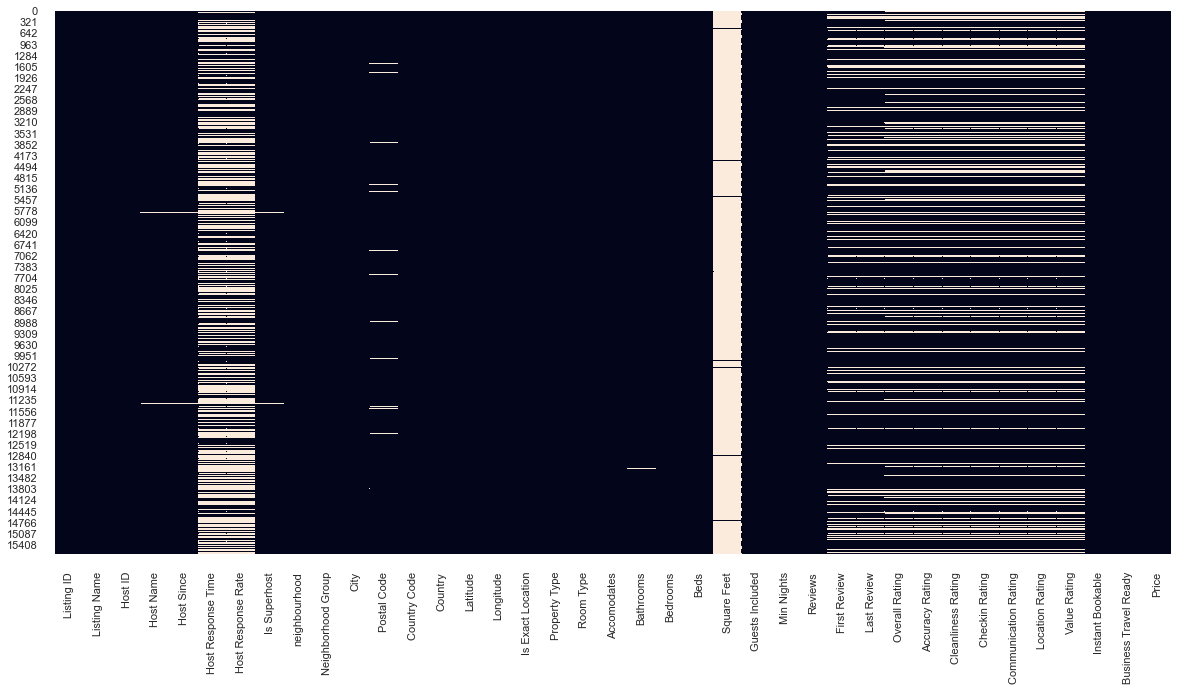

In [123]:
plt.figure(figsize=(20,10))
sns.heatmap(dataset.isna(),cbar=False)
plt.show()

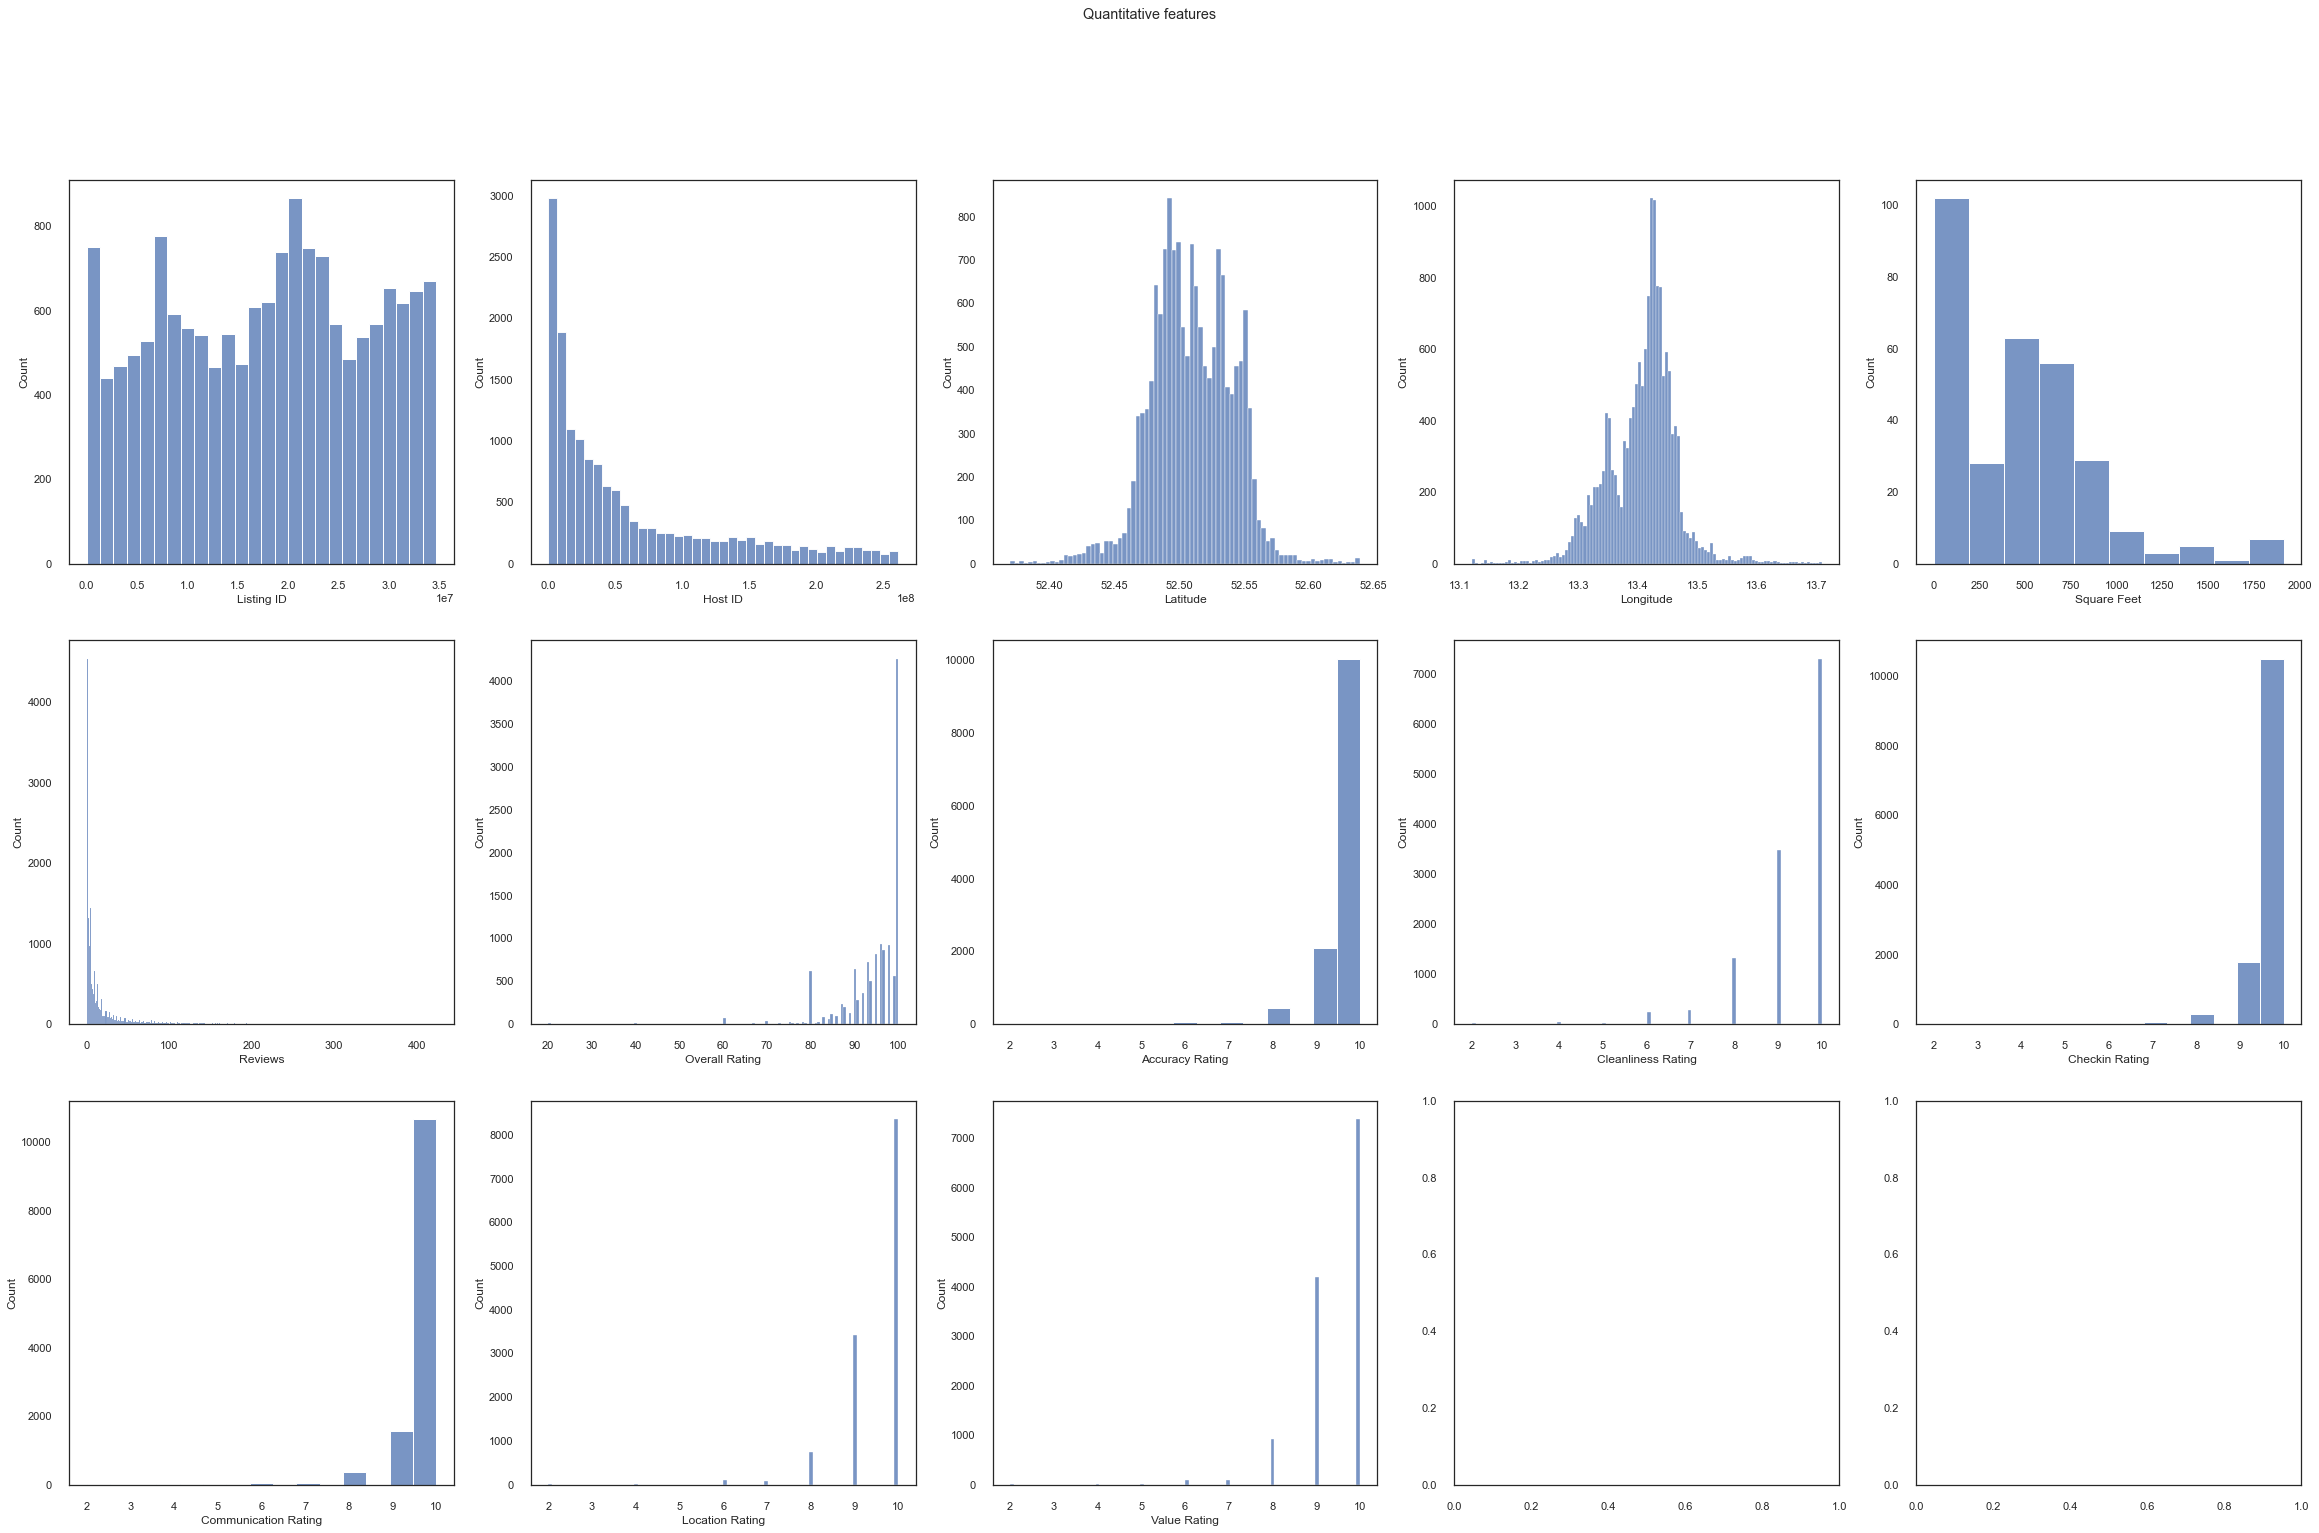

In [124]:
numerical_dataset = dataset.drop(["Price"], axis=1).select_dtypes(exclude=['object'])

fig, axes = plt.subplots(3,5, figsize=(8*5,8*3))
for i,col in enumerate(numerical_dataset):
    sns.histplot(dataset[col], ax=axes[i//5,i%5])
fig.suptitle("Quantitative features")
plt.show()

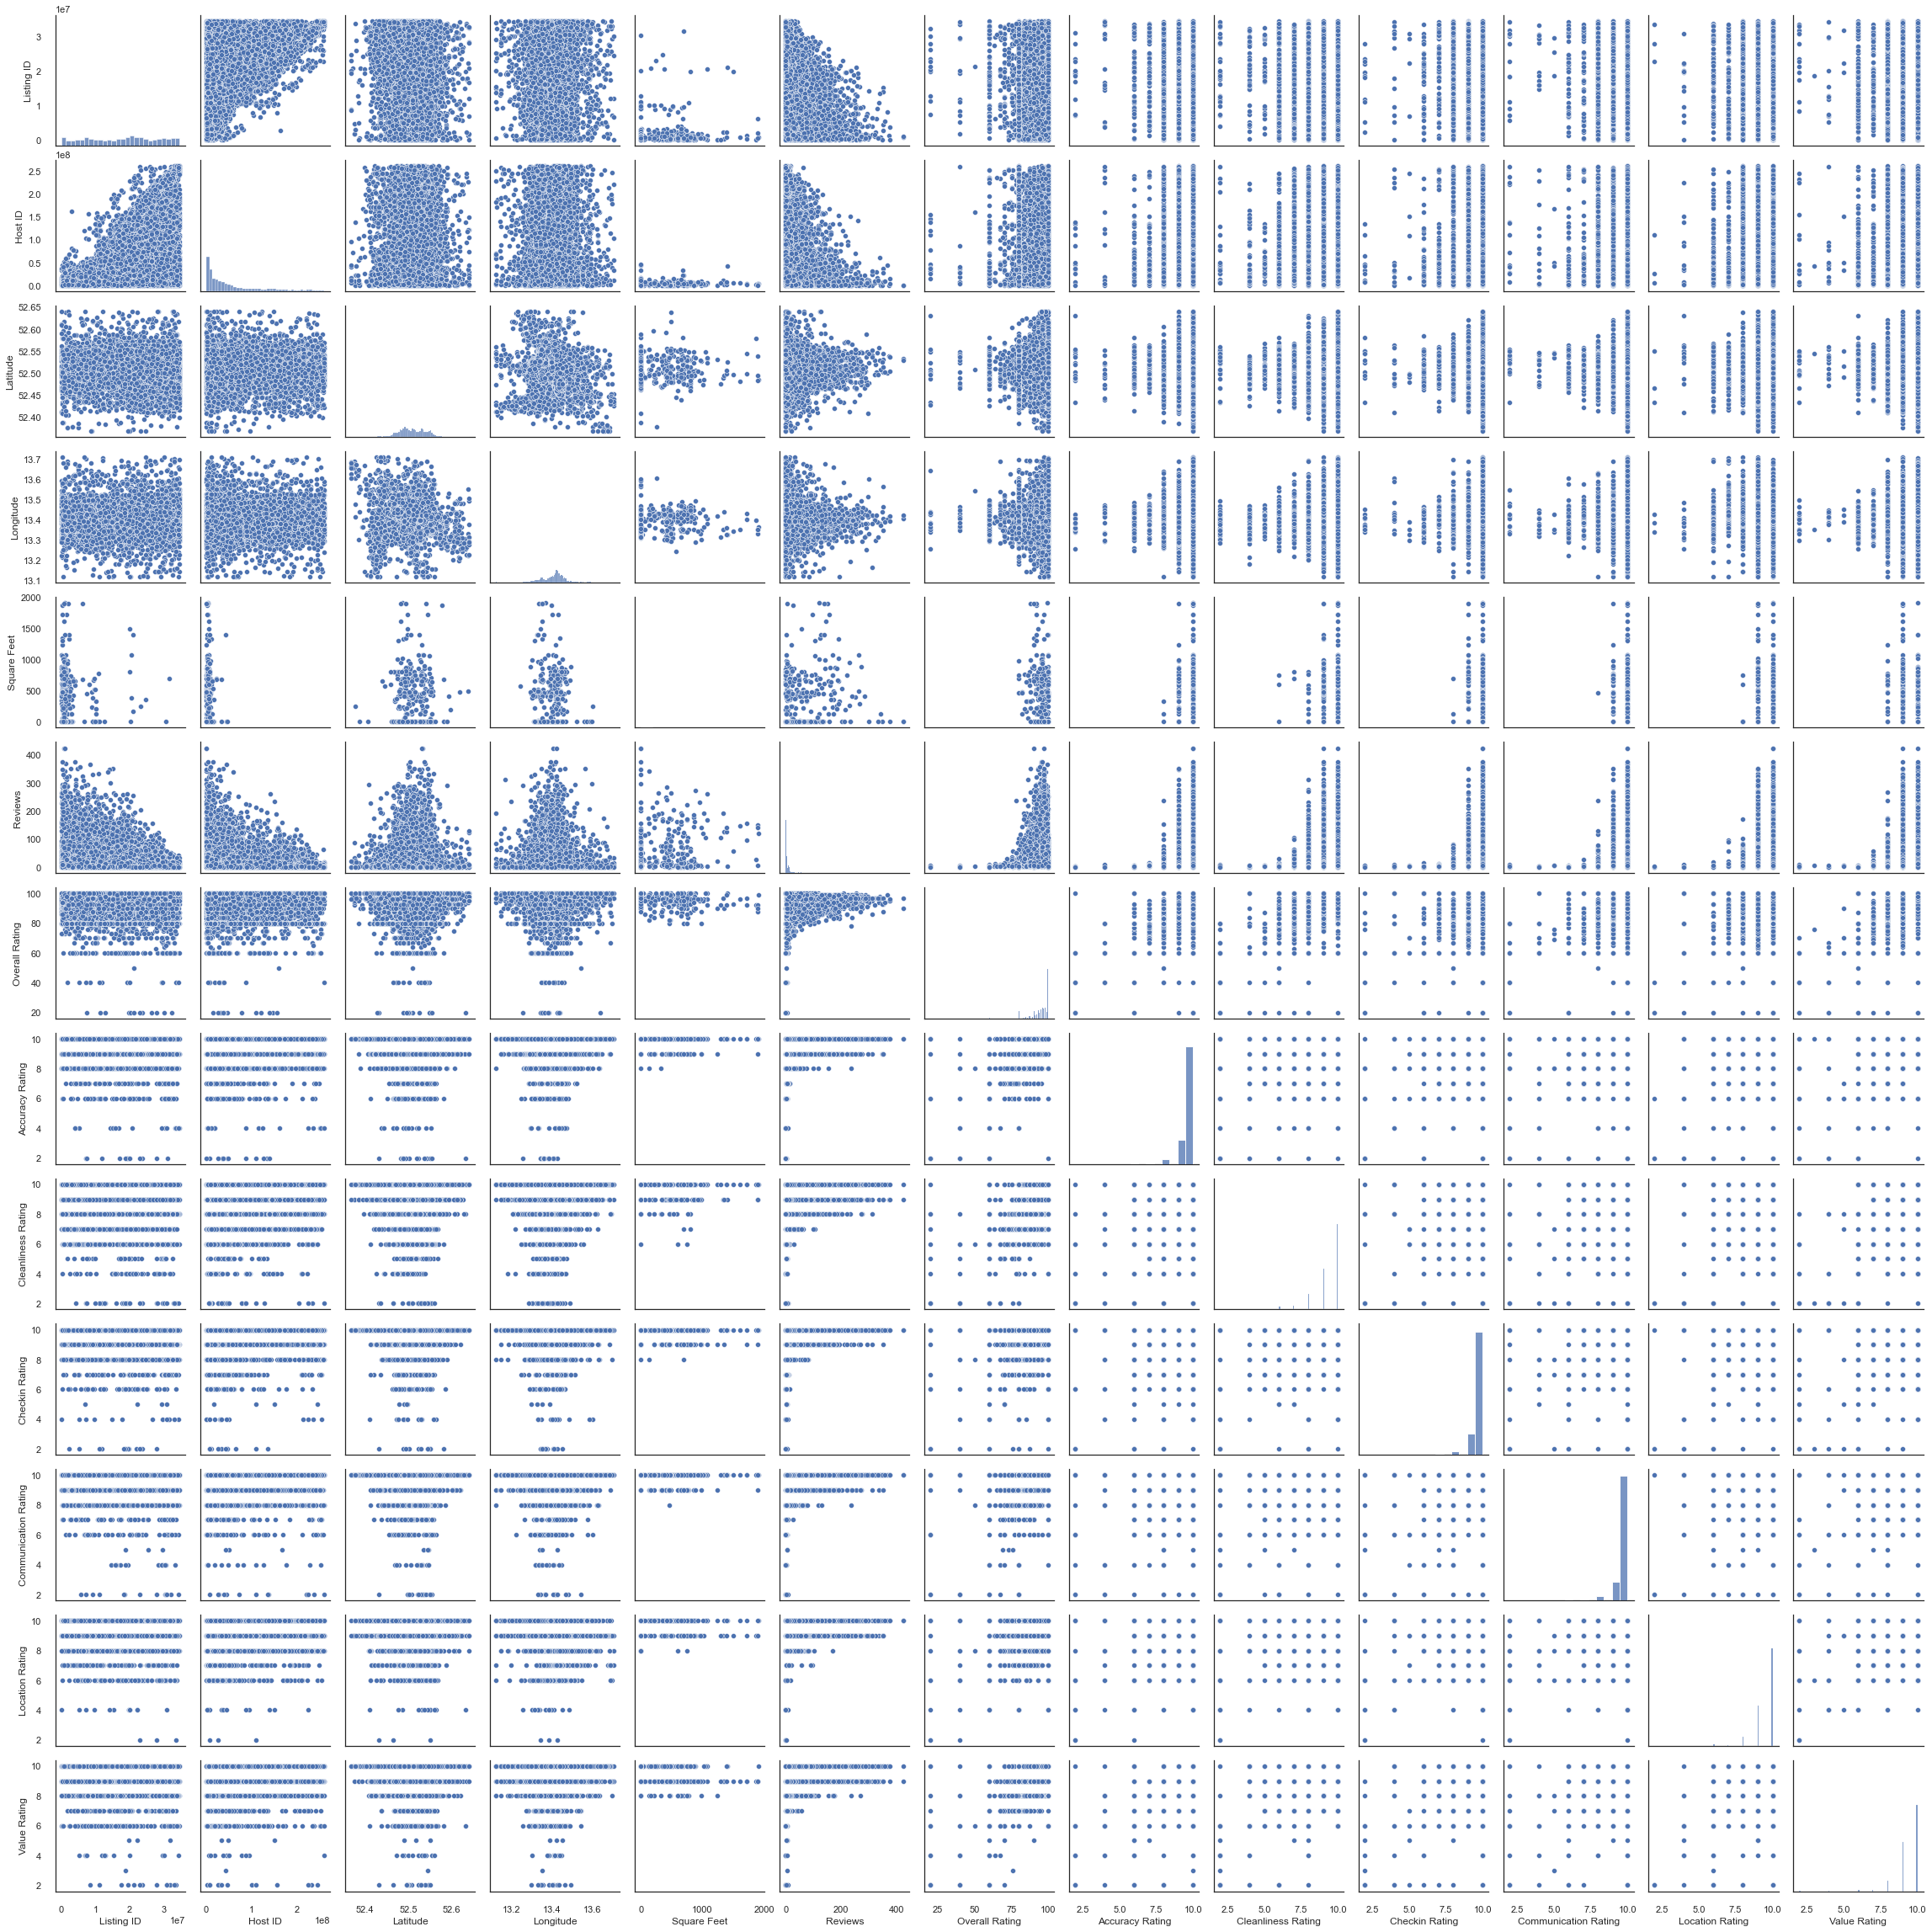

In [125]:
sns.pairplot(numerical_dataset)
plt.show()

<a href="#top">back to top</a>

<a name="analysis_per_col">
    
### Feature analysis

In [126]:
dataset_exp = dataset.copy()

#### Listing ID

<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable represents an id, then it can't be used
</div>

<a href="#top">back to top</a>

#### Listing Name

<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable represents a name, as we don't want to create biases in our model, we won't use it
</div>

<a href="#top">back to top</a>

#### Host ID

<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable represents an id, then it can't be used
</div>

<a href="#top">back to top</a>

#### Host Name

<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable represents a name, as we don't want to create biases in our model, we won't use it
</div>

<a href="#top">back to top</a>

#### Host Since

In [127]:
missing_values_rate_display("Host Since", dataset)

Missing value for Host Since columns: 0.134% (21/15692)
Star value for Host Since columns: 0.000% (0/15692)


In [128]:
dataset_host = dataset_exp[["Host Since", "Price"]].copy()
dataset_host["Host Since date"] = pd.to_datetime(dataset_host["Host Since"])
dataset_host["Host Since date year"] = dataset_host["Host Since date"].dt.year
dataset_host["Host Since date month"] = dataset_host["Host Since date"].dt.month

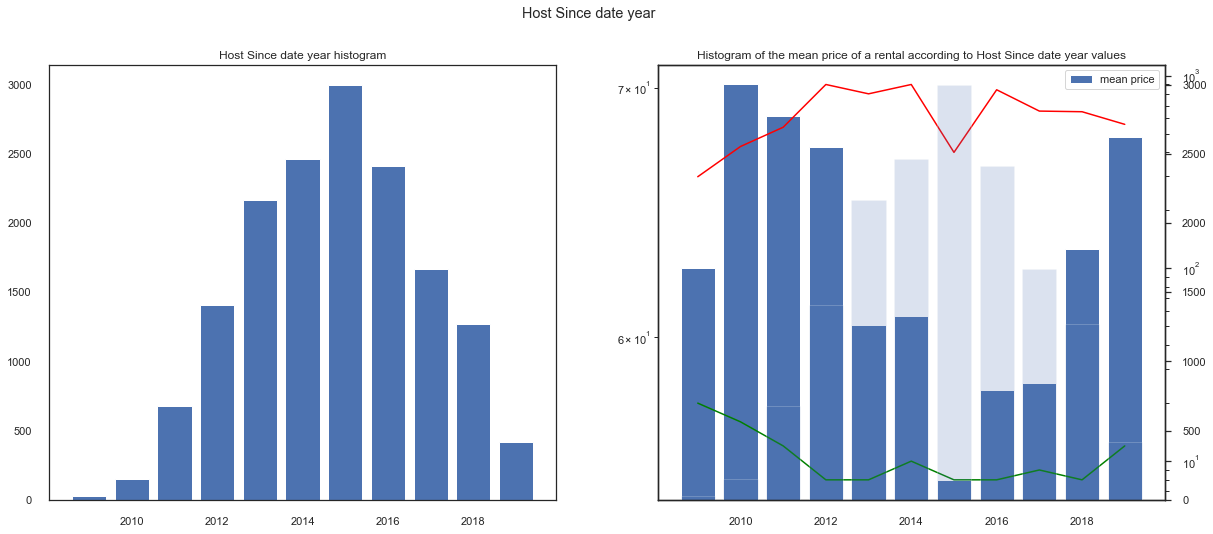

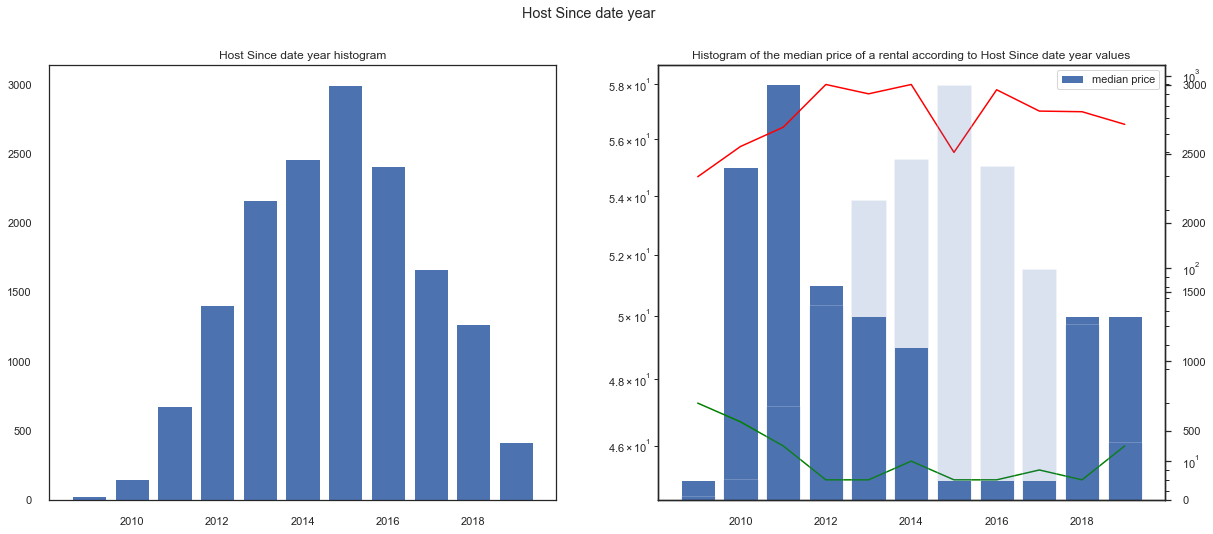

In [129]:
host_since_values = sorted(dataset_host["Host Since date year"].unique())
describe_feature("Host Since date year", host_since_values, dataset_host, mean_or_median='mean')
describe_feature("Host Since date year", host_since_values, dataset_host, mean_or_median='median')

In [130]:
dataset_host.pivot_table(
    index=["Host Since date year"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)

,min,max,mean,median
,Price,Price,Price,Price
Host Since date year,,,,
2009.0,20.0,299.0,62.629630,45.0
2010.0,16.0,429.0,70.141892,55.0
2011.0,12.0,540.0,68.786667,58.0
2012.0,8.0,900.0,67.474769,51.0
2013.0,8.0,805.0,60.432918,50.0
2014.0,10.0,900.0,60.773539,49.0
2015.0,8.0,400.0,54.931955,45.0
2016.0,8.0,845.0,58.055004,45.0


In [131]:
dataset_host.corr()

,Price,Host Since date year,Host Since date month
Price,1.000000,-0.031938,0.003326
Host Since date year,-0.031938,1.000000,-0.168135
Host Since date month,0.003326,-0.168135,1.000000


<div class="alert alert-block alert-warning">
<b>Conlusion:</b> We could use the year when the host create its account even if the correlations are low.
</div>

<a href="#top">back to top</a>

#### Host Response Time

In [40]:
missing_values_rate_display("Host Response Time", dataset)

Missing value for Host Response Time columns: 45.087% (7075/15692)
Star value for Host Response Time columns: 0.000% (0/15692)


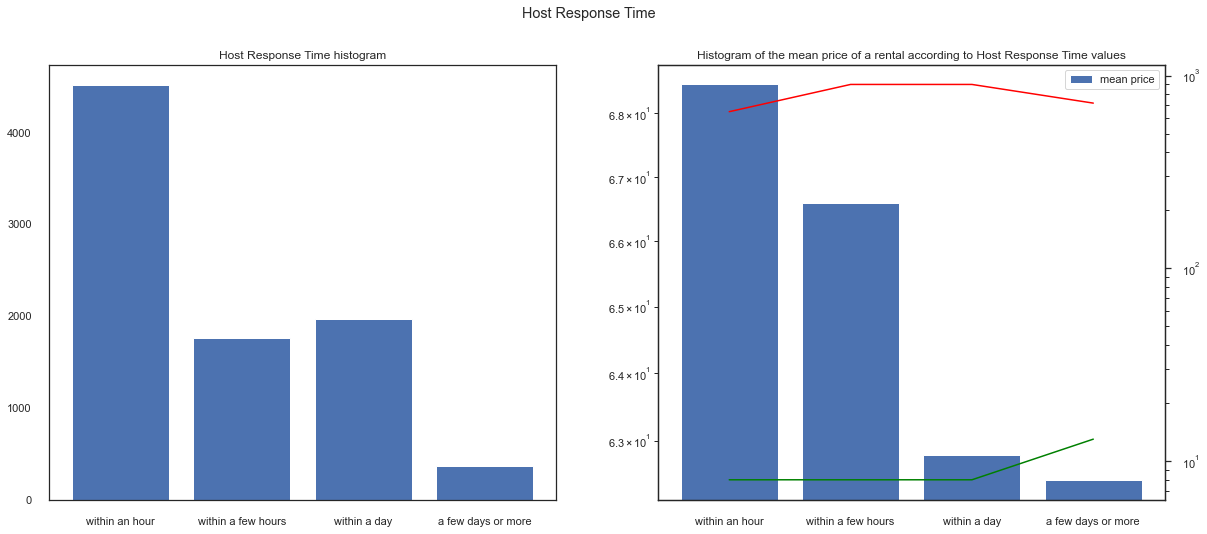

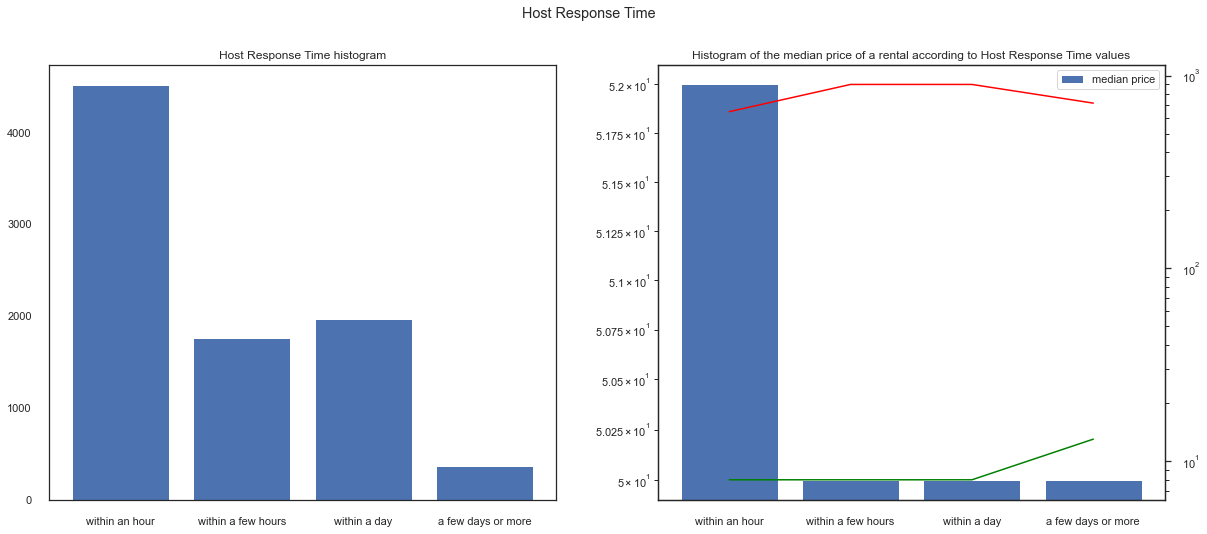

In [41]:
host_resp_time_modalities = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
describe_feature("Host Response Time", host_resp_time_modalities, dataset, mean_or_median='mean', display_hist=False)
describe_feature("Host Response Time", host_resp_time_modalities, dataset, mean_or_median='median', display_hist=False)

In [42]:
dataset.pivot_table(
    index=["Host Response Time"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)

,min,max,mean,median
,Price,Price,Price,Price
Host Response Time,,,,
a few days or more,13.0,720.0,62.427793,50.0
within a day,8.0,900.0,62.788403,50.0
within a few hours,8.0,900.0,66.585933,50.0
within an hour,8.0,650.0,68.459220,52.0
All,8.0,900.0,66.523234,50.0


In [43]:
dataset_host_resp_time_corr = dataset.copy(deep=True)[["Price", "Host Response Time"]]
ord_enc = OrdinalEncoder()
dataset_host_resp_time_corr[["Host Response Time"]] = ord_enc.fit_transform(dataset_host_resp_time_corr[["Host Response Time"]])
dataset_host_resp_time_corr.corr()

,Price,Host Response Time
Price,1.000000,0.044366
Host Response Time,0.044366,1.000000


<div class="alert alert-block alert-warning">
<b>Conlusion:</b> We could use the year when the host create its account even if the correlations are low.
</div>

<a href="#top">back to top</a>

#### Host Response Rate

In [44]:
missing_values_rate_display("Host Response Rate", dataset)

Missing value for Host Response Rate columns: 45.087% (7075/15692)
Star value for Host Response Rate columns: 1.109% (174/15692)


In [45]:
dataset_resp_rate = dataset_exp[["Host Response Rate","Price"]].dropna()
dataset_resp_rate = dataset_resp_rate.drop(dataset_resp_rate[dataset_resp_rate["Host Response Rate"] == "*"].index)
dataset_resp_rate["Host Response Rate"] = dataset_resp_rate["Host Response Rate"].apply(lambda x:x[:-1]).astype("int")

In [46]:
print(sorted(dataset_resp_rate["Host Response Rate"].unique()))

[0, 20, 25, 30, 33, 40, 50, 58, 60, 63, 67, 70, 71, 75, 78, 80, 82, 83, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


<div class="alert alert-block alert-info">
<b>First breakdown (based on distribution):</b><br>
<ul>
  <li>Rate &lt 1%</li>
  <li>1% &lt= Rate &lt 50%</li>
  <li>50% &lt= Rate &lt 60%</li>
  <li>60% &lt= Rate &lt 70%</li>
  <li>70% &lt= Rate &lt 80%</li>
  <li>80% &lt= Rate &lt 85%</li>
  <li>85% &lt= Rate &lt 90%</li>
  <li>90% &lt= Rate &lt 95%</li>
  <li>95% &lt= Rate &lt 100%</li>
  <li>Rate = 100%</li>
</ul>
</div>

In [47]:
resp_rate_vc = dataset_resp_rate["Host Response Rate"].value_counts()
bornes_basses = [0,1,50,60,70,80,85,90,95,100]
bornes_hautes = [1,50,60,70,80,85,90,95,100,101]
for bb, bh in zip(bornes_basses, bornes_hautes):
    nb = resp_rate_vc[(resp_rate_vc.index>=bb)&(resp_rate_vc.index<bh)].sum()
    print(f"{bb} <= Rate < {bh}: {nb} - {100*nb/resp_rate_vc.sum():.2f}%")

0 <= Rate < 1: 184 - 2.18%
1 <= Rate < 50: 140 - 1.66%
50 <= Rate < 60: 189 - 2.24%
60 <= Rate < 70: 204 - 2.42%
70 <= Rate < 80: 257 - 3.05%
80 <= Rate < 85: 297 - 3.52%
85 <= Rate < 90: 208 - 2.47%
90 <= Rate < 95: 582 - 6.90%
95 <= Rate < 100: 127 - 1.51%
100 <= Rate < 101: 6246 - 74.06%


In [48]:
# We transform this variable into a categorical one
dataset_resp_rate["Host Response Rate cat v1"] = dataset_resp_rate["Host Response Rate"]
resp_rate_cats = []
for bb, bh in zip(bornes_basses, bornes_hautes):
    name = f"{bb}-{bh}%"
    resp_rate_cats.append(name)
    dataset_resp_rate["Host Response Rate cat v1"].replace(
        list(range(bb,bh)), name, inplace=True
    )

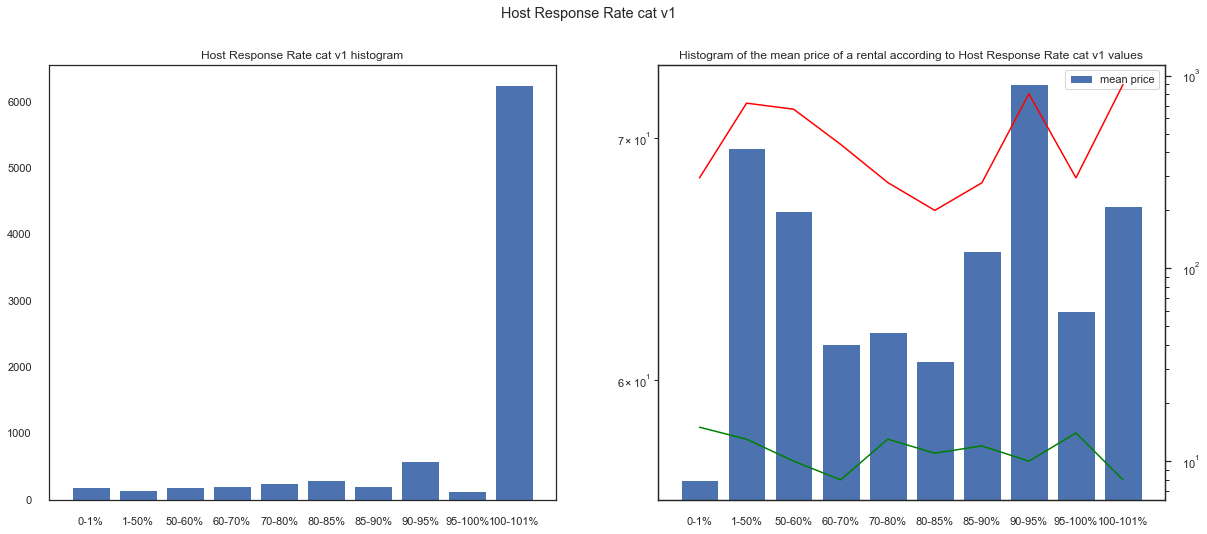

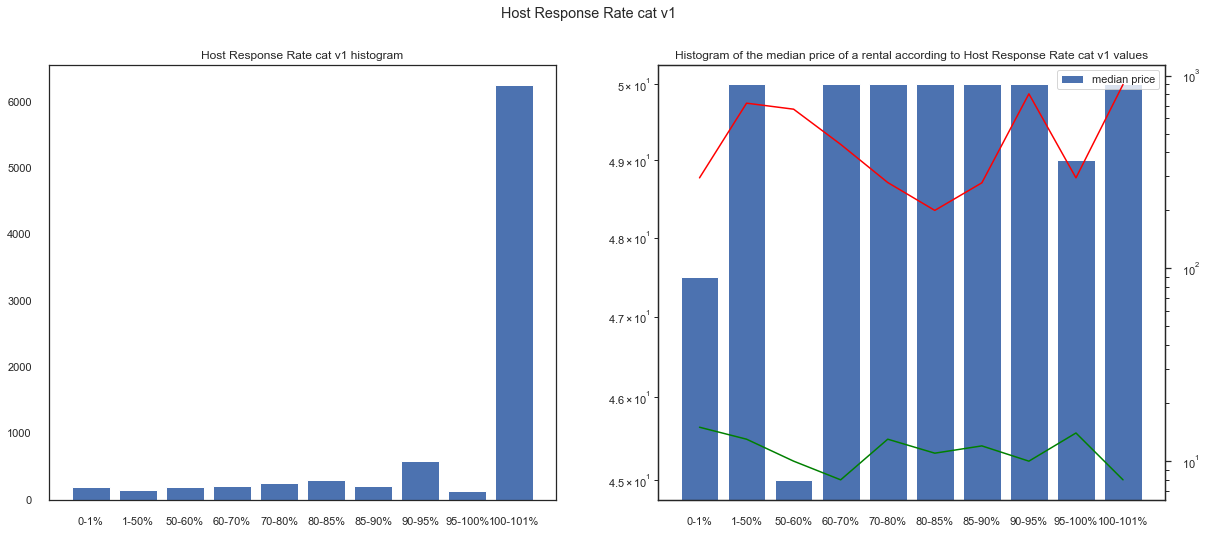

In [49]:
describe_feature("Host Response Rate cat v1", resp_rate_cats, dataset_resp_rate, mean_or_median='mean', display_hist=False)
describe_feature("Host Response Rate cat v1", resp_rate_cats, dataset_resp_rate, mean_or_median='median', display_hist=False)

<div class="alert alert-block alert-info">
<b>Second breakdown (based on distribution):</b><br>
<ul>
  <li>Rate &lt 1%</li>
  <li>1% &lt= Rate &lt 100%</li>
  <li>Rate = 100%</li>
</ul>
</div>

In [50]:
resp_rate_vc = dataset_resp_rate["Host Response Rate"].value_counts()
bornes_basses = [0,1,100]
bornes_hautes = [1,100,101]
for bb, bh in zip(bornes_basses, bornes_hautes):
    nb = resp_rate_vc[(resp_rate_vc.index>=bb)&(resp_rate_vc.index<bh)].sum()
    print(f"{bb} <= Rate < {bh}: {nb} - {100*nb/resp_rate_vc.sum():.2f}%")

0 <= Rate < 1: 184 - 2.18%
1 <= Rate < 100: 2004 - 23.76%
100 <= Rate < 101: 6246 - 74.06%


In [51]:
# We transform this variable into a categorical one
dataset_resp_rate["Host Response Rate cat v2"] = dataset_resp_rate["Host Response Rate"]
resp_rate_cats = []
for bb, bh in zip(bornes_basses, bornes_hautes):
    name = f"{bb}-{bh}%"
    resp_rate_cats.append(name)
    dataset_resp_rate["Host Response Rate cat v2"].replace(
        list(range(bb,bh)), name, inplace=True
    )

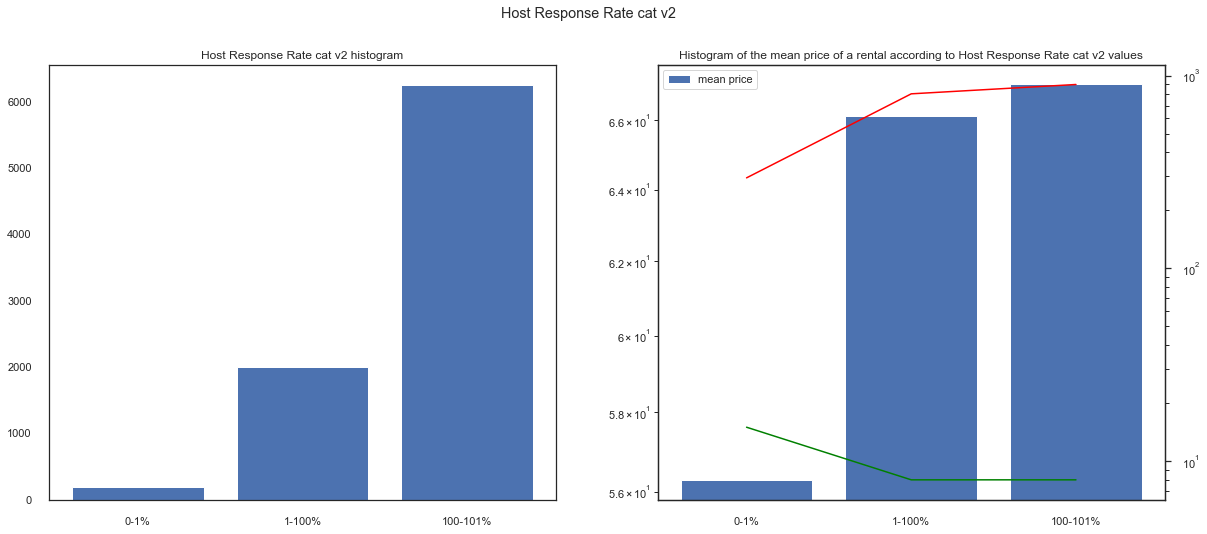

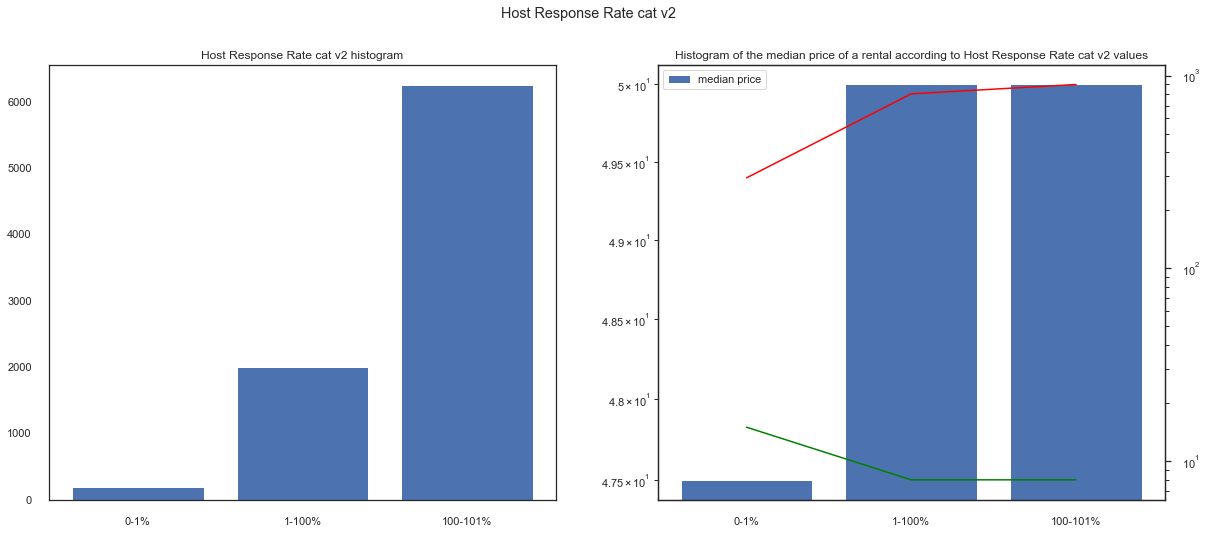

In [52]:
describe_feature("Host Response Rate cat v2", resp_rate_cats, dataset_resp_rate, mean_or_median='mean', display_hist=False)
describe_feature("Host Response Rate cat v2", resp_rate_cats, dataset_resp_rate, mean_or_median='median', display_hist=False)

In [53]:
dataset_resp_rate_corr = dataset_resp_rate.copy(deep=True)[["Price", "Host Response Rate", 
                                                            "Host Response Rate cat v1", "Host Response Rate cat v2"]]
ord_enc = OrdinalEncoder()
dataset_resp_rate_corr[["Host Response Rate cat v1", "Host Response Rate cat v2"]] = ord_enc.fit_transform(dataset_resp_rate_corr[["Host Response Rate cat v1", "Host Response Rate cat v2"]])
dataset_resp_rate_corr.corr()

,Price,Host Response Rate,Host Response Rate cat v1,Host Response Rate cat v2
Price,1.000000,0.027569,0.006687,0.021206
Host Response Rate,0.027569,1.000000,-0.034160,0.818135
Host Response Rate cat v1,0.006687,-0.034160,1.000000,-0.589536
Host Response Rate cat v2,0.021206,0.818135,-0.589536,1.000000


<div class="alert alert-block alert-warning">
<b>Conlusion:</b> It seems unnecessary to try to create a division. This variable bring too few informations.
</div>

<a href="#top">back to top</a>

#### Is Superhost

In [54]:
missing_values_rate_display("Is Superhost", dataset)

Missing value for Is Superhost columns: 0.147% (23/15692)
Star value for Is Superhost columns: 0.000% (0/15692)


In [55]:
dataset_superhost = dataset_exp[["Is Superhost",'Price']]
dataset_superhost = dataset_superhost.dropna()
dataset_superhost["Is Superhost"] = dataset_superhost["Is Superhost"].replace(["f","t"],["Not Superhost", "Superhost"])

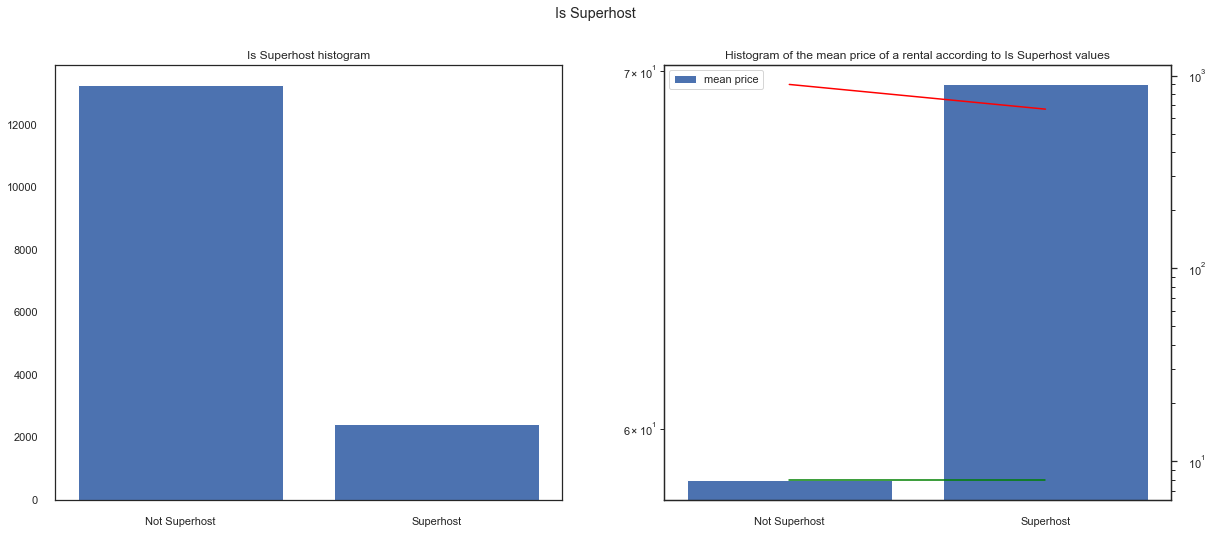

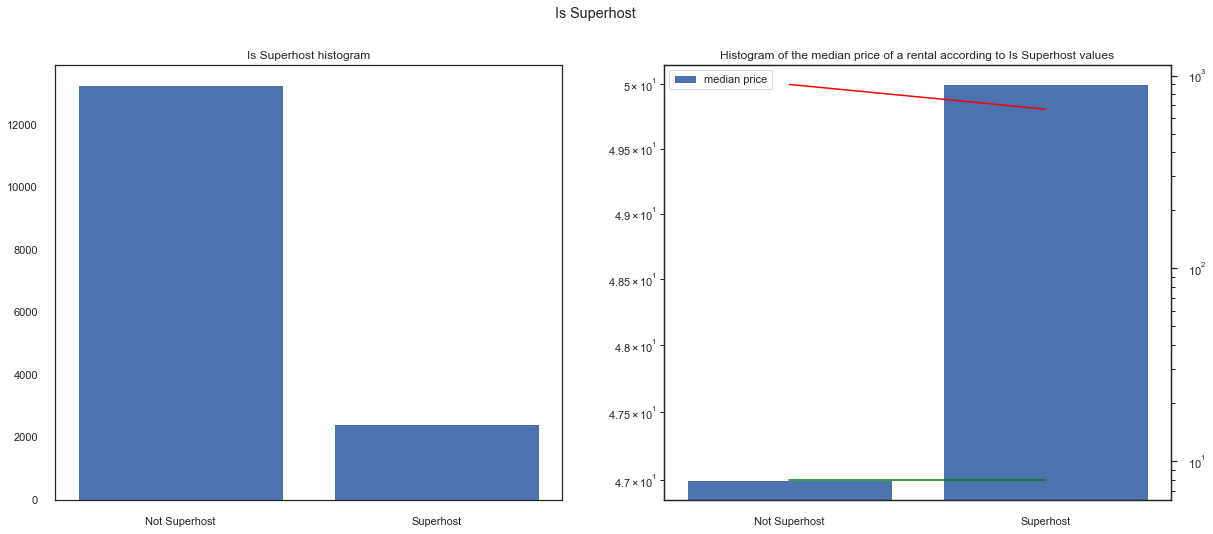

In [56]:
is_super_values = dataset_superhost["Is Superhost"].unique()
describe_feature("Is Superhost", is_super_values, dataset_superhost, mean_or_median='mean', display_hist=False)
describe_feature("Is Superhost", is_super_values, dataset_superhost, mean_or_median='median', display_hist=False)

In [57]:
dataset.pivot_table(
    index=["Host Response Time"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)

,min,max,mean,median
,Price,Price,Price,Price
Host Response Time,,,,
a few days or more,13.0,720.0,62.427793,50.0
within a day,8.0,900.0,62.788403,50.0
within a few hours,8.0,900.0,66.585933,50.0
within an hour,8.0,650.0,68.459220,52.0
All,8.0,900.0,66.523234,50.0


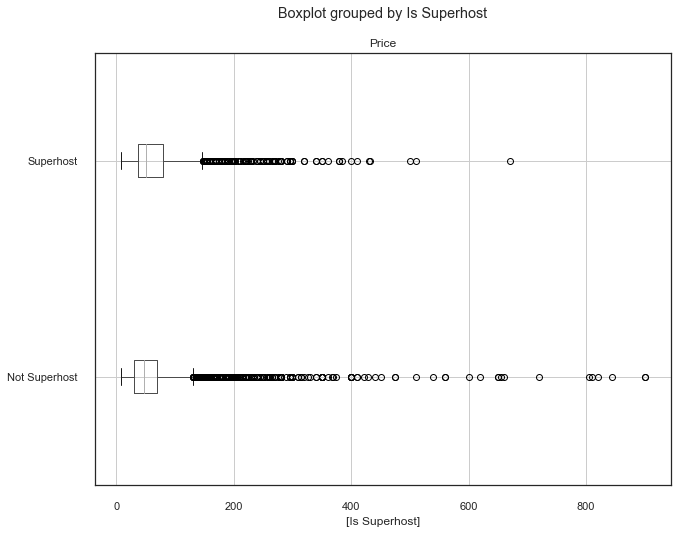

In [58]:
dataset_superhost.boxplot(by = 'Is Superhost', figsize=(10, 8), vert=False)
plt.show()

In [59]:
dataset_superhost_corr = dataset_superhost.copy(deep=True)[["Price", "Is Superhost"]]
ord_enc = OrdinalEncoder()
dataset_superhost_corr[["Host Response Time"]] = ord_enc.fit_transform(dataset_superhost_corr[["Is Superhost"]])
dataset_superhost_corr.corr()

,Price,Host Response Time
Price,1.000000,0.080518
Host Response Time,0.080518,1.000000


<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable bring too few informations but we will keep it at first in our model.
</div>

<a href="#top">back to top</a>

#### neighbourhood

In [60]:
missing_values_rate_display("neighbourhood", dataset)

Missing value for neighbourhood columns: 0.000% (0/15692)
Star value for neighbourhood columns: 1.294% (203/15692)


In [61]:
dataset_neigh = dataset_exp[dataset_exp["neighbourhood"]!="*"]

In [62]:
print(dataset_neigh["neighbourhood"].unique().shape[0], "neighbourhoods")
equal_neigh_group = 100*dataset_neigh.apply(lambda x: x.loc["neighbourhood"]==x.loc["Neighborhood Group"], axis=1).mean()
print(f"{equal_neigh_group:.1f}% neighbourhoods equal neighbourhood groups")

62 neighbourhoods
27.1% neighbourhoods equal neighbourhood groups


<div class="alert alert-block alert-info">
<p><b>Rq: </b>This second information (27.1% neighbourhoods equal neighbourhood groups) is interesting because since there are no missing values for the 'Neighbordhood Group' feature (more information in the related section), we could simply replace the values with a star by the 'Neighbordhood Group' value of the relative instance</p>
</div>

In [63]:
dataset_neigh.pivot_table(
    index=["neighbourhood"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)

,min,max,mean,median
,Price,Price,Price,Price
neighbourhood,,,,
Adlershof,14.0,110.0,48.631579,30.0
Alt-HohenschÃ¶nhausen,17.0,125.0,44.375000,38.0
Alt-Treptow,15.0,279.0,54.349593,45.0
Altglienicke,17.0,120.0,46.588235,30.0
Baumschulenweg,10.0,145.0,42.109375,35.5
...,...,...,...,...
Wilhelmstadt,30.0,290.0,80.250000,56.5
Wilmersdorf,13.0,650.0,67.739264,50.0


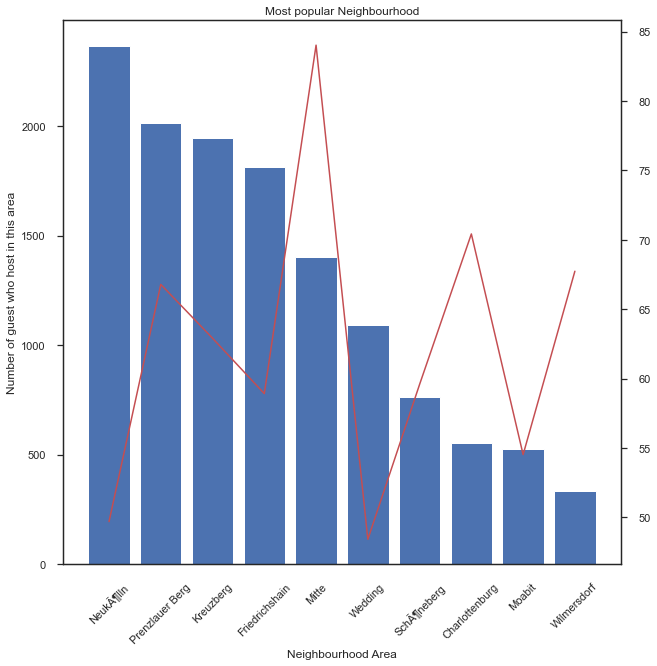

In [64]:
fig, ax = plt.subplots(figsize=(10,10))
data = dataset_neigh["neighbourhood"].value_counts()[:10]
mean_price = dataset_neigh[["neighbourhood", "Price"]].groupby(["neighbourhood"])["Price"].mean().reindex(data.index)[:10]

x = data.index
y_ = data.values

plt.title("Most popular Neighbourhood")
plt.xlabel("Neighbourhood Area")
plt.ylabel("Number of guest who host in this area")
plt.xticks(rotation=45)
plt.bar(x,y_)

ax2=ax.twinx()

plt.plot(mean_price.index, mean_price.values, c="r")

plt.show()

<div class="alert alert-block alert-info">
    <b>Encoding idea:</b><br>
    <p>As the feature contains too much possible values, using a OneHotEncoder would not be relevant. Then, we have considered another encoder: LeaveOneOutEncoder.</p>
    <p><b>Idea: </b>We take the mean of a variable for all rows with the same id except for the current row, so as to avoid leakage.</p>
</div>

In [65]:
dataset_neigh_X = dataset_neigh[["neighbourhood"]]
dataset_neigh_y = dataset_neigh[ "Price"]
encoder = ce.LeaveOneOutEncoder(cols=["neighbourhood"])
encoder.fit(dataset_neigh_X, dataset_neigh_y)
dataset_neigh_X = encoder.transform(dataset_neigh_X)
dataset_neigh_X["Price"] = dataset_neigh_y
dataset_neigh_X.corr()

,neighbourhood,Price
neighbourhood,1.000000,0.217822
Price,0.217822,1.000000


<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable can be interesting to use with the LeaveOneOut Encoder
</div>

<a href="#top">back to top</a>

#### Neighborhood Group

In [66]:
missing_values_rate_display("Neighborhood Group", dataset)

Missing value for Neighborhood Group columns: 0.000% (0/15692)
Star value for Neighborhood Group columns: 0.000% (0/15692)


In [67]:
print(dataset["Neighborhood Group"].unique().shape[0], "Neighborhood Group")

12 Neighborhood Group


In [68]:
dataset.pivot_table(
    index=["Neighborhood Group"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)

,min,max,mean,median
,Price,Price,Price,Price
Neighborhood Group,,,,
Charlottenburg-Wilm.,8.0,650.0,68.653447,51.0
Friedrichshain-Kreuzberg,8.0,450.0,61.033439,50.0
Lichtenberg,11.0,475.0,51.028846,42.0
Marzahn - Hellersdorf,13.0,276.0,57.188976,45.0
Mitte,8.0,845.0,66.632840,50.0
NeukÃ¶lln,10.0,660.0,49.642915,40.0
Pankow,9.0,900.0,64.868985,50.0
Reinickendorf,8.0,340.0,45.247706,36.0


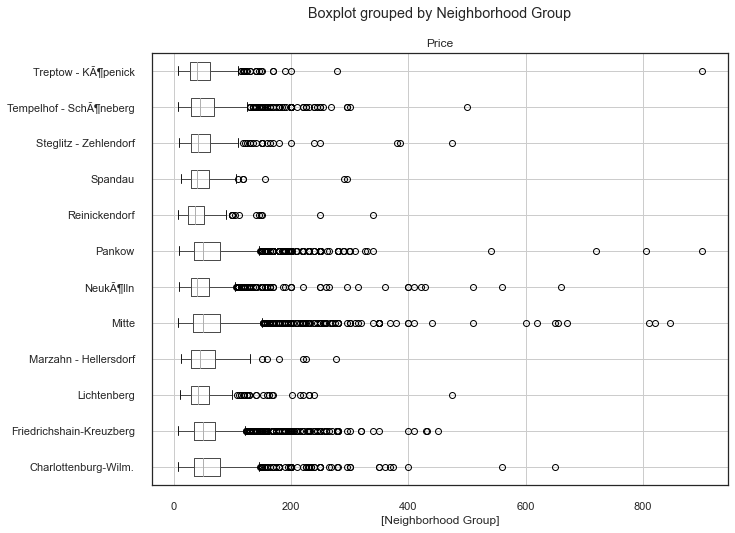

In [69]:
dataset[['Neighborhood Group','Price']].boxplot(by = 'Neighborhood Group', figsize=(10, 8), vert=False)
plt.show()

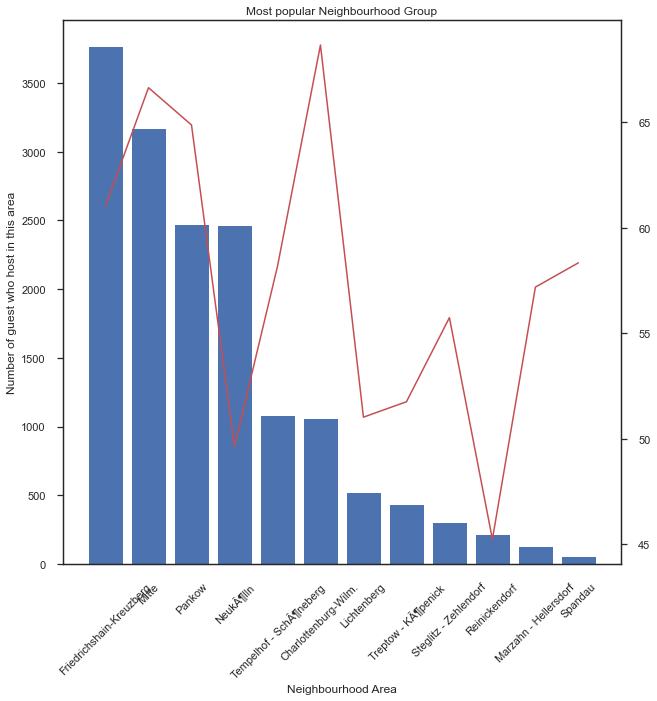

In [70]:
fig, ax = plt.subplots(figsize=(10,10))
data = dataset["Neighborhood Group"].value_counts()
mean_price = dataset[["Neighborhood Group", "Price"]].groupby(["Neighborhood Group"])["Price"].mean().reindex(data.index)

x = data.index
y_ = data.values

plt.title("Most popular Neighbourhood Group")
plt.xlabel("Neighbourhood Area")
plt.ylabel("Number of guest who host in this area")
plt.xticks(rotation=45)
plt.bar(x,y_)

ax2=ax.twinx()

plt.plot(mean_price.index, mean_price.values, c="r")

plt.show()

In [71]:
dataset_neighG_X = dataset[["Neighborhood Group"]]
dataset_neighG_y = dataset[ "Price"]
encoder = ce.LeaveOneOutEncoder(cols=["Neighborhood Group"])
encoder.fit(dataset_neighG_X, dataset_neighG_y)
dataset_neighG_X = encoder.transform(dataset_neighG_X)
dataset_neighG_X["Price"] = dataset_neighG_y
dataset_neighG_X["neighbourhood"] = dataset_neigh_X["neighbourhood"]
dataset_neighG_X.corr()

,Neighborhood Group,Price,neighbourhood
Neighborhood Group,1.000000,0.134236,0.612838
Price,0.134236,1.000000,0.217822
neighbourhood,0.612838,0.217822,1.000000


<div class="alert alert-block alert-warning">
<b>Conlusion:</b> This variable can be interesting to use with the LeaveOneOut Encoder but it gives redondancy (coeff of correlation equal to 0.61) with the neighboroud feature who has the highest correlation
</div>

<a href="#top">back to top</a>

#### City

In [72]:
missing_values_rate_display("City", dataset)

Missing value for City columns: 0.006% (1/15692)
Star value for City columns: 0.300% (47/15692)


In [73]:
print("Possible values of the 'City' feature:\n",dataset["City"].unique())

Possible values of the 'City' feature:
 ['Berlin' '*' nan]


<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable can't be used because it contains only one possible value
</div>

<a href="#top">back to top</a>

#### Postal Code

In [74]:
missing_values_rate_display("Postal Code", dataset)

Missing value for Postal Code columns: 1.459% (229/15692)
Star value for Postal Code columns: 5.544% (870/15692)


<div class="alert alert-block alert-warning">
<b>Conlusion:</b> This variable create data redundancy with neighborhood
</div>

<a href="#top">back to top</a>

#### Country Code

In [75]:
missing_values_rate_display("Country Code", dataset)

Missing value for Country Code columns: 0.000% (0/15692)
Star value for Country Code columns: 0.000% (0/15692)


In [76]:
print("Possible values of the 'Country Code' feature:\n",dataset["Country Code"].unique())

Possible values of the 'Country Code' feature:
 ['DE']


<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable can't be used because it contains only one possible value
</div>

<a href="#top">back to top</a>

#### Country

In [77]:
missing_values_rate_display("Country", dataset)

Missing value for Country columns: 0.000% (0/15692)
Star value for Country columns: 0.000% (0/15692)


In [78]:
print("Possible values of the 'Country' feature:\n",dataset.Country.unique())

Possible values of the 'Country' feature:
 ['Germany']


<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable can't be used because it contains only one possible value
</div>

<a href="#top">back to top</a>

#### Latitude & Longitude

In [79]:
missing_values_rate_display("Latitude", dataset)

Missing value for Latitude columns: 0.000% (0/15692)
Star value for Latitude columns: 0.000% (0/15692)


In [80]:
missing_values_rate_display("Longitude", dataset)

Missing value for Longitude columns: 0.000% (0/15692)
Star value for Longitude columns: 0.000% (0/15692)


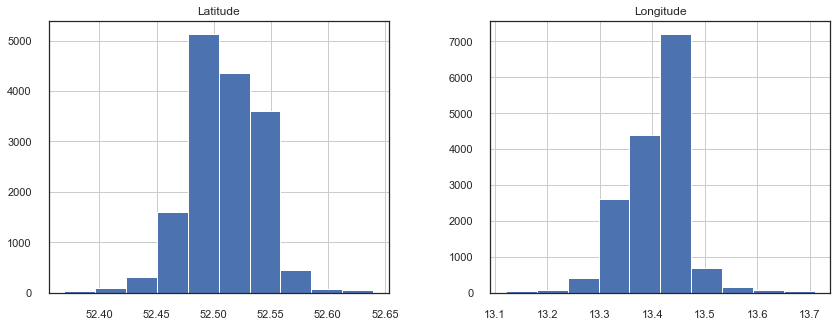

In [81]:
dataset[["Latitude","Longitude"]].hist(figsize=(14,5))
plt.show()

In [82]:
dataset[["Latitude","Longitude","Price"]].corr()

,Latitude,Longitude,Price
Latitude,1.000000,-0.125704,0.039158
Longitude,-0.125704,1.000000,-0.041581
Price,0.039158,-0.041581,1.000000


<div class="alert alert-block alert-warning">
<b>Conlusion:</b> This variables create data redundancy with neighborhood
</div>

<a href="#top">back to top</a>

#### Is Exact Location

In [83]:
missing_values_rate_display("Is Exact Location", dataset)

Missing value for Is Exact Location columns: 0.000% (0/15692)
Star value for Is Exact Location columns: 0.000% (0/15692)


<div class="alert alert-block alert-success">
<b>Conlusion:</b> No correlations
</div>

<a href="#top">back to top</a>

#### Property Type

In [84]:
missing_values_rate_display("Property Type", dataset)

Missing value for Property Type columns: 0.000% (0/15692)
Star value for Property Type columns: 0.478% (75/15692)


<div class="alert alert-block alert-success">
<b>Conlusion:</b> Good correlations
</div>

<a href="#top">back to top</a>

#### Room Type

In [85]:
missing_values_rate_display("Room Type", dataset)

Missing value for Room Type columns: 0.000% (0/15692)
Star value for Room Type columns: 0.000% (0/15692)


<div class="alert alert-block alert-success">
<b>Conlusion:</b> Very high correlations
</div>

<a href="#top">back to top</a>

#### Accomodates

In [86]:
missing_values_rate_display("Accomodates", dataset)

Missing value for Accomodates columns: 0.000% (0/15692)
Star value for Accomodates columns: 0.121% (19/15692)


<div class="alert alert-block alert-success">
<b>Conlusion:</b> Very high correlations
</div>

<a href="#top">back to top</a>

#### Bathrooms

In [87]:
missing_values_rate_display("Bathrooms", dataset)

Missing value for Bathrooms columns: 0.089% (14/15692)
Star value for Bathrooms columns: 0.070% (11/15692)


<div class="alert alert-block alert-success">
<b>Conlusion:</b> Good correlations
</div>

<a href="#top">back to top</a>

#### Bedrooms

In [88]:
missing_values_rate_display("Bedrooms", dataset)

Missing value for Bedrooms columns: 0.032% (5/15692)
Star value for Bedrooms columns: 0.070% (11/15692)


<div class="alert alert-block alert-success">
<b>Conlusion:</b> Good correlations
</div>

<a href="#top">back to top</a>

#### Beds (nb de lits double avec accomodates)

In [89]:
missing_values_rate_display("Beds", dataset)

Missing value for Beds columns: 0.051% (8/15692)
Star value for Beds columns: 0.076% (12/15692)


<div class="alert alert-block alert-success">
<b>Conlusion:</b> Good correlations
</div>

<a href="#top">back to top</a>

#### Square Feet

In [90]:
missing_values_rate_display("Square Feet", dataset)

Missing value for Square Feet columns: 98.069% (15389/15692)
Star value for Square Feet columns: 0.000% (0/15692)


<div class="alert alert-block alert-info">
<b>Rq:</b> We could use other features to estimate its value, but it would create dependence between variables</div>

<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable can't be use, it contains too much missing values
</div>

<a href="#top">back to top</a>

#### Guests Included

In [91]:
missing_values_rate_display("Guests Included", dataset)

Missing value for Guests Included columns: 0.000% (0/15692)
Star value for Guests Included columns: 0.064% (10/15692)


<div class="alert alert-block alert-success">
<b>Conlusion:</b> Maybe need PCA
</div>

<a href="#top">back to top</a>

#### Min Nights

In [92]:
missing_values_rate_display("Min Nights", dataset)

Missing value for Min Nights columns: 0.000% (0/15692)
Star value for Min Nights columns: 1.587% (249/15692)


<div class="alert alert-block alert-danger">
<b>Conlusion:</b> No correlations
</div>

<a href="#top">back to top</a>

#### Reviews

In [93]:
missing_values_rate_display("Reviews", dataset)

Missing value for Reviews columns: 0.000% (0/15692)
Star value for Reviews columns: 0.000% (0/15692)


<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable could be used
</div>

<a href="#top">back to top</a>

#### First Review & Last Review

In [94]:
missing_values_rate_display("First Review", dataset)
missing_values_rate_display("Last Review", dataset)

Missing value for First Review columns: 17.238% (2705/15692)
Star value for First Review columns: 0.000% (0/15692)
Missing value for Last Review columns: 17.244% (2706/15692)
Star value for Last Review columns: 0.000% (0/15692)


In [23]:
from datetime import datetime


df=dataset.copy()
df1=pd.DataFrame(pd.to_datetime(df['First Review'].dropna()))
df['timestamp'] = df1[['First Review']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
df['day FR']=pd.to_datetime(df['First Review']).dt.day
df['month FR']=pd.to_datetime(df['First Review']).dt.month
df['year FR']=pd.to_datetime(df['First Review']).dt.year

df1=pd.DataFrame(pd.to_datetime(df['Last Review'].dropna()))
df['timestamp LR'] = df1[['Last Review']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
df['day LR']=pd.to_datetime(df['Last Review']).dt.day
df['month LR']=pd.to_datetime(df['Last Review']).dt.month
df['year LR']=pd.to_datetime(df['Last Review']).dt.year

first_column = df.pop('Price')
df.insert(0, 'Price', first_column)
df.dropna
df

,Price,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,City,Postal Code,Country Code,Country,Latitude,Longitude,Is Exact Location,Property Type,Room Type,...,Reviews,First Review,Last Review,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready,timestamp,day FR,month FR,year FR,timestamp LR,day LR,month LR,year LR
0,26.0,19665213.0,*,156079597.0,Maximilian,2016-01-20,NaN,NaN,f,Prenzlauer Berg,Pankow,Berlin,10437.0,DE,Germany,52.54652,13.41792,t,Apartment,Private room,...,6,2017-07-07,2017-08-08,100.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,1.499386e+09,7.0,7.0,2017.0,1.502150e+09,8.0,8.0,2017.0
1,41.0,6436842.0,*,5302290.0,Dulie,2013-04-07,NaN,NaN,f,Pankow,Pankow,Berlin,13187.0,DE,Germany,52.56512,13.42214,t,Apartment,Entire home/apt,...,6,2015-05-26,2019-04-30,90.0,9.0,9.0,10.0,10.0,9.0,10.0,f,f,1.432598e+09,26.0,5.0,2015.0,1.556582e+09,30.0,4.0,2019.0
2,50.0,10559468.0,*,59151456.0,Geank,2016-02-07,NaN,NaN,f,Prenzlauer Berg,Pankow,Berlin,10439.0,DE,Germany,52.54741,13.42521,t,Apartment,Entire home/apt,...,2,2016-04-19,2016-07-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,1.461024e+09,19.0,4.0,2016.0,1.467590e+09,4.0,7.0,2016.0
3,50.0,27215482.0,*,193452785.0,Alix,2018-06-26,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,Berlin,10245,DE,Germany,52.50958,13.45144,t,Apartment,Private room,...,4,2018-07-31,2018-08-12,100.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,1.532995e+09,31.0,7.0,2018.0,1.534032e+09,12.0,8.0,2018.0
4,55.0,27287546.0,*,205870244.0,Lurina,2013-05-16,within a few hours,92%,t,Prenzlauer Berg,Pankow,Berlin,10405.0,DE,Germany,52.52995,13.41558,t,Apartment,Private room,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15687,45.0,12936631.0,*,19460983.0,Ascharl,2013-06-22,a few days or more,33%,f,Kreuzberg,Friedrichshain-Kreuzberg,Berlin,10961.0,DE,Germany,52.49016,13.39241,t,Apartment,Private room,...,11,2016-09-15,2019-01-02,98.0,10.0,9.0,10.0,10.0,10.0,10.0,f,f,1.473898e+09,15.0,9.0,2016.0,1.546387e+09,2.0,1.0,2019.0
15688,130.0,8207346.0,*,30411910.0,Marki,2015-04-19,NaN,NaN,f,NeukÃ¶lln,NeukÃ¶lln,Berlin,12055.0,DE,Germany,52.47586,13.45362,t,Apartment,Entire home/apt,...,4,2016-04-15,2016-07-31,100.0,10.0,9.0,10.0,10.0,10.0,9.0,f,f,1.460678e+09,15.0,4.0,2016.0,1.469923e+09,31.0,7.0,2016.0
15689,19.0,12246808.0,*,89972306.0,Ada,2016-08-11,NaN,NaN,f,Wedding,Mitte,Berlin,13351.0,DE,Germany,52.54196,13.34179,t,Apartment,Private room,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15690,100.0,10886411.0,*,10108952.0,Lanna,2015-12-06,within a day,50%,f,SchÃ¶neberg,Tempelhof - SchÃ¶neberg,Berlin,12159.0,DE,Germany,52.47179,13.33103,t,Apartment,Entire home/apt,...,6,2016-04-07,2018-08-07,90.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,1.459987e+09,7.0,4.0,2016.0,1.533600e+09,7.0,8.0,2018.0


<AxesSubplot:>

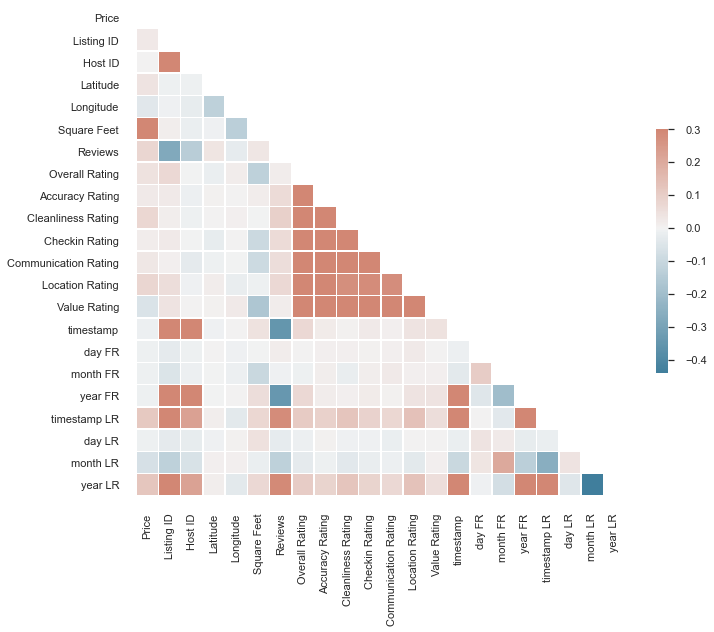

In [97]:
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<div class="alert alert-block alert-success">
<b>Conlusion:</b> Year of last review could be used whereas all other features related to last and first reviews are useless.
</div>

<a href="#top">back to top</a>

#### Ratings
- Overall Rating
- Accuracy Rating
- Cleanliness Rating
- Checkin Rating
- Communication Rating
- Location Rating
- Value Rating

In [72]:
ratings = ["Overall Rating", "Accuracy Rating", "Cleanliness Rating",
           "Checkin Rating", "Communication Rating", "Location Rating",
           "Value Rating"]
for r in ratings:
    missing_values_rate_display(r, dataset)
    print()

Missing value for Overall Rating columns: 18.876% (2962/15692)
Star value for Overall Rating columns: 0.000% (0/15692)

Missing value for Accuracy Rating columns: 18.933% (2971/15692)
Star value for Accuracy Rating columns: 0.000% (0/15692)

Missing value for Cleanliness Rating columns: 18.927% (2970/15692)
Star value for Cleanliness Rating columns: 0.000% (0/15692)

Missing value for Checkin Rating columns: 18.946% (2973/15692)
Star value for Checkin Rating columns: 0.000% (0/15692)

Missing value for Communication Rating columns: 18.927% (2970/15692)
Star value for Communication Rating columns: 0.000% (0/15692)

Missing value for Location Rating columns: 18.933% (2971/15692)
Star value for Location Rating columns: 0.000% (0/15692)

Missing value for Value Rating columns: 18.940% (2972/15692)
Star value for Value Rating columns: 0.000% (0/15692)



We can notice that all ratings have the same proportion of missing values. We should study all ratings together.

In [99]:
corr_matrix = df[["Overall Rating", "Accuracy Rating", "Cleanliness Rating",
           "Checkin Rating", "Communication Rating", "Location Rating",
           "Value Rating","Price"]].corr()
corr_matrix["Price"].sort_values(ascending=False)

Price                   1.000000
Location Rating         0.076058
Cleanliness Rating      0.072634
Overall Rating          0.043537
Communication Rating    0.028882
Accuracy Rating         0.022770
Checkin Rating          0.014200
Value Rating           -0.057623
Name: Price, dtype: float64

<a href="#top">back to top</a>

<div class="alert alert-block alert-success">
<b>Conlusion:</b> We could use: Cleanliness, Location although their corelations with Price remain low.
</div>

#### Instant Bookable

In [73]:
missing_values_rate_display("Instant Bookable", dataset)

Missing value for Instant Bookable columns: 0.000% (0/15692)
Star value for Instant Bookable columns: 0.000% (0/15692)


<div class="alert alert-block alert-warning">
<b>Conlusion:</b> The correlations are too low.
</div>

<a href="#top">back to top</a>

#### Business Travel Ready

In [74]:
missing_values_rate_display("Business Travel Ready", dataset)

Missing value for Business Travel Ready columns: 0.000% (0/15692)
Star value for Business Travel Ready columns: 0.000% (0/15692)


In [75]:
dataset["Business Travel Ready"].value_counts()

f    15692
Name: Business Travel Ready, dtype: int64

<div class="alert alert-block alert-danger">
<b>Conlusion:</b> This variable can't be used because it contains only one possible value
</div>

<a href="#top">back to top</a>

<a name="target_analysis">

### Target analysis

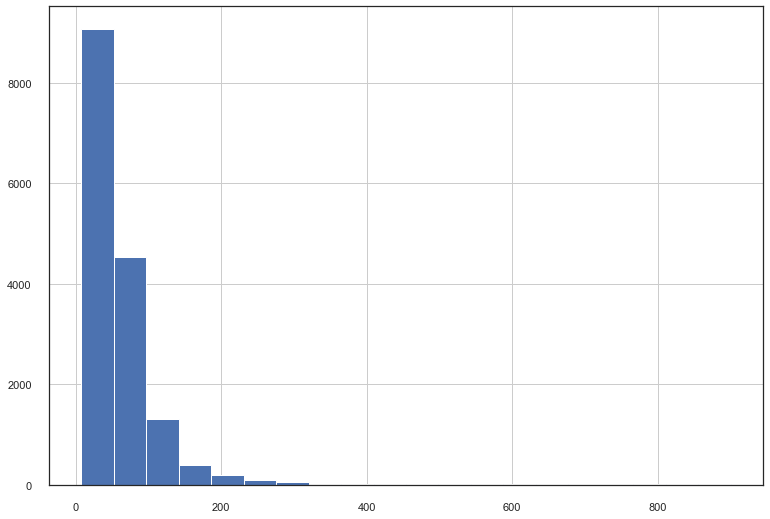

In [132]:
dataset.Price.hist(bins=20)
plt.show()

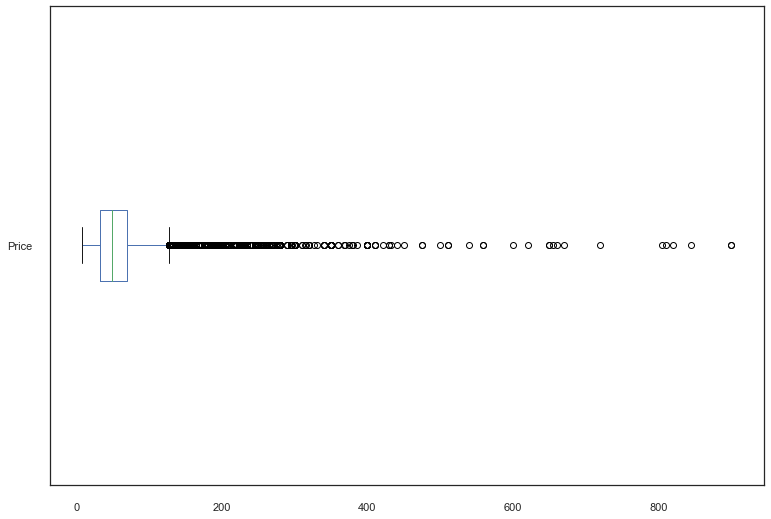

In [133]:
dataset.Price.plot.box(vert=False)
plt.show()

In [134]:
print("Price",
      f"Mean: {dataset.Price.mean():.2f}",
      f"Median: {dataset.Price.median()}",
      f"Min: {dataset.Price.min()}",
      f"Max: {dataset.Price.max()}",
      sep='\n'
     )

Price
Mean: 60.34
Median: 49.0
Min: 8.0
Max: 900.0


<a href="#top">back to top</a>

<a name="pca">

### PCA

<a href="#top">back to top</a>

<a name="conclusion">

### Conclusion

We create 3 categories for our features:
<ul>
    <li>
        <b>Features with a good correlation to the rental price that will be used for our model:</b>
        <ul>
            <li><font color='green'>Is Superhost</font></li>
            <li><font color='green'>neighbourhood</font></li>
            <li><font color='green'>Property Type</font></li>
            <li><font color='green'>Room Type</font></li>
            <li><font color='green'>Accomodates</font></li>
            <li><font color='green'>Bathrooms</font></li>
            <li><font color='green'>Bedrooms</font></li>
            <li><font color='green'>Beds</font></li>
            <li><font color='green'>Guests Included</font></li>
            <li><font color='green'>Reviews</font></li>
            <li><font color='green'>Last Review (year)</font></li>
            <li><font color='green'>Cleanliness Rating</font></li>
            <li><font color='green'>Location Rating</font></li>
            <li><font color='green'>Value Rating</font></li>
        </ul>
    </li>
    <li>
        <b>Features with a low correlation to the rental price or feature that create data redundancy:</b>
        <ul>
            <li><font color='orange'>Host since</font> (too low correlations)</li>
            <li><font color='orange'>Host Response Rate</font> (too low correlations)</li>
            <li><font color='orange'>Neighborhood Group</font> (redundancy with neighbourhood)</li>
            <li><font color='orange'>Postal Code</font> (redundancy with neighbourhood)</li>
            <li><font color='orange'>Latitude et Longitude</font> (redundancy with neighbourhood)</li>
            <li><font color='orange'>Instant Bookable </font> (too low correlations)</li>
            <li><font color='orange'>First Review </font> (too low correlations)</li>
            <li><font color='orange'>Overall Rating </font> (too low correlations)</li>
            <li><font color='orange'>Accuracy Rating </font> (too low correlations)</li>
            <li><font color='orange'>Communication Rating </font> (too low correlations)</li>
        </ul>
    </li>
    <li>
        <b>Features that can't be used:</b>
        <ul>
            <li><font color='red'>Host Name</font> (no exploitable informations)</li>
            <li><font color='red'>Host ID</font> (no exploitable informations)</li>
            <li><font color='red'>Listing Name</font> (no exploitable informations)</li>
            <li><font color='red'>Listing ID</font> (no exploitable informations)</li>
            <li><font color='red'>Postal Code</font> (redundancy)</li>
            <li><font color='red'>Country Code</font> (only one value)</li>
            <li><font color='red'>Country</font> (only one value)</li>
            <li><font color='red'>City</font> (only one value)</li>
            <li><font color='red'>Business Travel Ready</font> (only one value)</li>
            <li><font color='red'>square_feet</font> (too much missing values)</li>
            <li><font color='red'>Is Exact Location </font> (no correlations)</li>
            <li><font color='red'>Min Nights </font> (no correlations)</li>
            <li><font color='red'>Checkin Rating </font> (no correlations)</li>
        </ul>
    </li>
</ul>


<a href="#top">back to top</a>

<a name="preprocessing">

## Preprocessing
---

<a name="feat_selec">

### Feature selection

We choose the following features:

In [203]:
feature_names = ["Is Superhost","neighbourhood","Property Type","Room Type","Accomodates","Bathrooms",
                 "Bedrooms","Beds","Guests Included","Reviews","Last Review","Cleanliness Rating",
                 "Location Rating","Value Rating"]
dataset_select = dataset.copy()
dataset_select = dataset_select[feature_names+["Price"]]

<a href="#top">back to top</a>

<a name="missing_values">

### Missing values (NaN et *)

**Target (Price):** There are only 9 missing values for the target, so we will drop them

In [204]:
dataset_without_na = dataset_select.copy()
dataset_without_na.dropna(subset="Price", inplace=True)
dataset_without_na.reset_index(inplace=True, drop=True)

TypeError: Index(...) must be called with a collection of some kind, 'Price' was passed

**Features**

In [205]:
dataset_without_na = dataset_without_na.dropna()
for col in dataset_without_na.columns:
    dataset_without_na[col] = dataset_without_na[dataset_without_na[col]!="*"][col]
    dataset_without_na = dataset_without_na[~dataset_without_na[col].isna()]
dataset_without_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12434 entries, 0 to 15690
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Is Superhost        12434 non-null  object 
 1   neighbourhood       12434 non-null  object 
 2   Property Type       12434 non-null  object 
 3   Room Type           12434 non-null  object 
 4   Accomodates         12434 non-null  object 
 5   Bathrooms           12434 non-null  object 
 6   Bedrooms            12434 non-null  object 
 7   Beds                12434 non-null  object 
 8   Guests Included     12434 non-null  object 
 9   Reviews             12434 non-null  int64  
 10  Last Review         12434 non-null  object 
 11  Cleanliness Rating  12434 non-null  float64
 12  Location Rating     12434 non-null  float64
 13  Value Rating        12434 non-null  float64
 14  Price               12434 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 1.5

<a href="#top">back to top</a>

<a name="split">

### Split

In [206]:
X = dataset_without_na.drop("Price", axis=1)
y = dataset_without_na["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)
print(X_train.shape,y_train.shape)

(8703, 14) (8703,)


<a href="#top">back to top</a>

<a name="cat_feat">

### Categorical features

In [207]:
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

features_float_enc = ["Accomodates", "Bathrooms", "Bedrooms", "Beds", "Guests Included"]
features_ordinal_enc = ["Is Superhost", "Room Type"] # one hot
features_LOO_enc = ["neighbourhood", "Property Type"]

X_train_encoded[features_float_enc] = X_train.astype({col:float for col in features_float_enc})[features_float_enc]
X_test_encoded[features_float_enc] = X_test.astype({col:float for col in features_float_enc})[features_float_enc]

ordinal_encoder = OrdinalEncoder()
X_train_encoded[features_ordinal_enc] = ordinal_encoder.fit_transform(X_train[features_ordinal_enc])
X_test_encoded[features_ordinal_enc] = ordinal_encoder.transform(X_test[features_ordinal_enc])

for col in features_LOO_enc:
    loo_encoder = ce.LeaveOneOutEncoder(cols=[col])
    loo_encoder.fit(X_train[col], y_train)
    X_train_encoded[col] = loo_encoder.transform(X_train[col])
    X_test_encoded[col] = loo_encoder.transform(X_test[col])

X_train_encoded['Last Review'] = pd.to_datetime(X_train['Last Review']).dt.year.values
X_test_encoded['Last Review'] = pd.to_datetime(X_test['Last Review']).dt.year.values

<a href="#top">back to top</a>

<a name="scaling">

### Scaling

In [208]:
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

#features_to_scale_minmax = []
features_to_scale_norm = X_train_scaled.columns

#X_train_scaled[features_to_scale_minmax] = minmax_scaler.fit_transform(X_train[features_to_scale_minmax])
#X_test_scaled[features_to_scale_minmax] = minmax_scaler.transform(X_test[features_to_scale_minmax])
X_train_scaled[features_to_scale_norm] = standard_scaler.fit_transform(X_train_encoded[features_to_scale_norm])
X_test_scaled[features_to_scale_norm] = standard_scaler.transform(X_test_encoded[features_to_scale_norm])

<a href="#top">back to top</a>

<a name="feature_eng">

### Feature engineering

In [209]:
#X_train_feature_eng = X_train_scaled.copy()
#X_test_feature_eng = X_test_scaled.copy()

<div class="alert alert-block alert-info">
<b>Rq:</b> Maybe we could append a new feature which represent the distance to center</div>

<a href="#top">back to top</a>

<a name="modeling">

## Modeling

In [210]:
X_train_cleaned = X_train_encoded.copy()
X_test_cleaned = X_test_encoded.copy()

X_train_cleaned_scaled = X_train_scaled.copy()
X_test_cleaned_scaled = X_test_scaled.copy()

<a name="linear">

### Linear Regression

In [211]:
model = LinearRegression()
model.fit(X_train_cleaned, y_train)
r2 = model.score(X_test_cleaned, y_test)

y_preds = model.predict(X_test_cleaned)
mse = mean_squared_error(y_test, y_preds)

print("Linear Regression",
      f"mse = {mse:.2f}",
      f"r2 = {r2:.2f}",
     sep="\n")

Linear Regression
mse = 1292.12
r2 = 0.43


In [213]:
model = LinearRegression()
model.fit(X_train_cleaned_scaled, y_train)
r2 = model.score(X_test_cleaned_scaled, y_test)

y_preds = model.predict(X_test_cleaned_scaled)
mse = mean_squared_error(y_test, y_preds)

print("Linear Regression",
      f"mse = {mse:.2f}",
      f"r2 = {r2:.2f}",
     sep="\n")

Linear Regression
mse = 1292.12
r2 = 0.43


#### Feature selection

#### Grid Search

#### Scoring

<a href="#top">back to top</a>

<a name="svm">

### SVM

In [193]:
model = SVR()
model.fit(X_train_cleaned, y_train)
r2 = model.score(X_test_cleaned, y_test)

y_preds = model.predict(X_test_cleaned)
mse = mean_squared_error(y_test, y_preds)

print("SVM",
      f"mse = {mse:.2f}",
      f"r2 = {r2:.2f}",
     sep="\n")

SVM
mse = 2421.07
r2 = -0.06


In [194]:
model = SVR()
model.fit(X_train_cleaned_scaled, y_train)
r2 = model.score(X_test_cleaned_scaled, y_test)

y_preds = model.predict(X_test_cleaned_scaled)
mse = mean_squared_error(y_test, y_preds)

print("SVM",
      f"mse = {mse:.2f}",
      f"r2 = {r2:.2f}",
     sep="\n")

SVM
mse = 1625.22
r2 = 0.29


#### Feature selection

#### Grid Search

#### Scoring

<a href="#top">back to top</a>

<a name="gb">

### GradientBoostingRegressor

In [195]:
model = GradientBoostingRegressor()
model.fit(X_train_cleaned, y_train)
r2 = model.score(X_test_cleaned, y_test)

y_preds = model.predict(X_test_cleaned)
mse = mean_squared_error(y_test, y_preds)

print("Gradient Boosting",
      f"mse = {mse:.2f}",
      f"r2 = {r2:.2f}",
     sep="\n")

Gradient Boosting
mse = 1294.98
r2 = 0.43


#### Feature selection

<a href="#top">back to top</a>

<a name="DT">

### Decision Tree

In [222]:
model = tree.DecisionTreeRegressor(max_depth=10,min_samples_split=125)
model.fit(X_train_cleaned, y_train)
r2 = model.score(X_test_cleaned, y_test)

y_preds = model.predict(X_test_cleaned)
mse = mean_squared_error(y_test, y_preds)

print("Decision Tree",
      f"mse = {mse:.2f}",
      f"r2 = {r2:.2f}",
     sep="\n")

Decision Tree
mse = 1412.70
r2 = 0.38


#### Feature selection

#### Grid Search

In [223]:
pgrid = {"max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
      "min_samples_split": [2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 80, 100, 125, 150, 200]}
grid_search = GridSearchCV(tree.DecisionTreeRegressor(), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)


grid_search.fit(X_train_cleaned, y_train)
grid_search.best_estimator_.score(X_test_cleaned, y_test)

print("Les paramètres à choisir sont: ", grid_search.best_params_)

Les paramètres à choisir sont:  {'max_depth': 10, 'min_samples_split': 125}


#### Scoring

<a href="#top">back to top</a>

<a name="BG">

### Bagging

#### Feature selection

#### GridSearch

#### Scoring

<a href="#top">back to top</a>

<a name="RF">

### Random Forest

In [248]:
model = RandomForestRegressor(max_features=0.3, max_depth=10,n_estimators=800)
model.fit(X_train_cleaned, y_train)
r2 = model.score(X_test_cleaned, y_test)

y_preds = model.predict(X_test_cleaned)
mse = mean_squared_error(y_test, y_preds)

print("Random Forest",
      f"mse = {mse:.2f}",
      f"r2 = {r2:.2f}",
     sep="\n")

Random Forest
mse = 1254.68
r2 = 0.45


#### Feature selection

#### Grid search

Temps de calcul =68.13661909103394


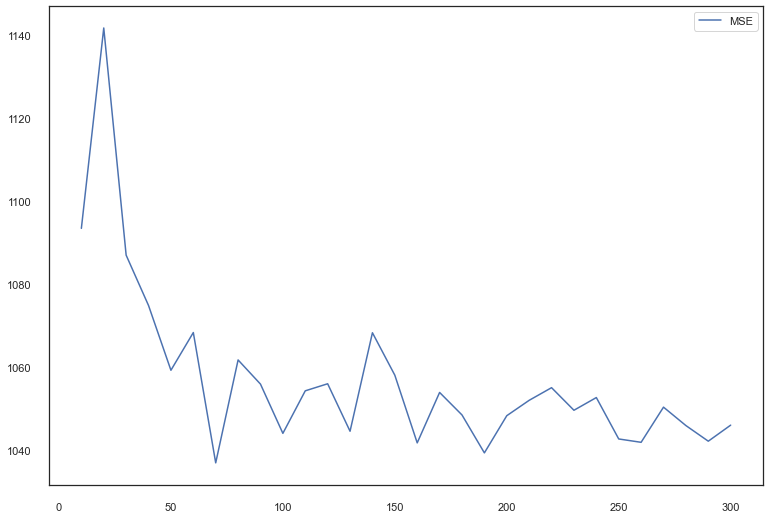

In [201]:
N = 30
mse = np.zeros(N)

tic=time.time()

for i in range(N):
    X_train, X_test, y_train1, y_test = train_test_split(X_train_cleaned_scaled, y_train, train_size=0.7, random_state=0)
    reg = RandomForestRegressor(n_estimators=(i+1)*10)
    reg.fit(X_train, y_train1)
    Z = reg.predict(X_test)
    mse [i] = mean_squared_error(y_test, Z)

toc=time.time()

print("Temps de calcul = "+str(toc-tic)+"sec")

plt.plot([10*(i+1) for i in range(30)], mse, label="MSE")
plt.legend()
plt.show()

In [242]:
pgrid = {"max_depth": [1, 3, 5, 8, 10],
        "max_features": [0.1, 0.2, 0.3, 0.5],
        'n_estimators': [100, 150, 200, 250]
        }



grid_search = GridSearchCV(RandomForestRegressor(), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)


grid_search.fit(X_train_cleaned, y_train)
best_score=grid_search.best_estimator_.score(X_test_cleaned, y_test)
best_max_features=grid_search.best_estimator_.max_features
best_max_depth=grid_search.best_estimator_.max_depth
best_n_estimators=grid_search.best_estimator_.n_estimators
print("best_score ", best_score)
print("best_max_features ", best_max_features)
print("best_max_depth ", best_max_depth)
print("best_n_estimators ", best_n_estimators)


best_score  0.45335299077267244
best_max_features  0.3
best_max_depth  10
best_n_estimators  200


In [227]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

<a href="#top">back to top</a>

<a name="ET">

### Extra Treees

In [260]:
model = ExtraTreesRegressor(max_features=0.3, max_depth=10,n_estimators=800)
model.fit(X_train_cleaned, y_train)
r2 = model.score(X_test_cleaned, y_test)

y_preds = model.predict(X_test_cleaned)
mse = mean_squared_error(y_test, y_preds)

print("ExtraTrees",
      f"mse = {mse:.2f}",
      f"r2 = {r2:.2f}",
     sep="\n")

ExtraTrees
mse = 1280.77
r2 = 0.44


#### Feature selection

#### GridSearch

In [253]:
pgrid = {"max_depth": [1, 3, 5, 8, 10],
        "max_features": [0.1, 0.2, 0.3, 0.5],
        'n_estimators': [100, 150, 200, 250]
        }



grid_search = GridSearchCV(ExtraTreesRegressor(), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)


grid_search.fit(X_train_cleaned, y_train)
best_score=grid_search.best_estimator_.score(X_test_cleaned, y_test)
best_max_features=grid_search.best_estimator_.max_features
best_max_depth=grid_search.best_estimator_.max_depth
best_n_estimators=grid_search.best_estimator_.n_estimators
print("best_score ", best_score)
print("best_max_features ", best_max_features)
print("best_max_depth ", best_max_depth)
print("best_n_estimators ", best_n_estimators)

best_score  0.43516402339668114
best_max_features  0.3
best_max_depth  10
best_n_estimators  100


<a href="#top">back to top</a>

<a name="best_model">

## Best model
---

<a href="#top">back to top</a>